# Bitcoin Prices - Time Series Analysis:
- Halving Events
- Stationarity check - Augmented Dickey–Fuller test and seasonality checks
- Frequency plots
- Simple Moving Average
- Decomposition Charts
- ACF & PACF
- Prophet
- Holt-Winters Model
- ARIMA
- GARCH

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot

#### Having a look at our data

In [3]:
bitcoin_data = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'])

In [4]:
bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Average
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1


In [5]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5282 non-null   datetime64[ns]
 1   Price     5282 non-null   float64       
 2   Open      5282 non-null   float64       
 3   High      5282 non-null   float64       
 4   Low       5282 non-null   float64       
 5   Vol.      5276 non-null   object        
 6   Change %  5282 non-null   object        
 7   Average   5282 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 330.2+ KB


In [6]:
bitcoin_data.describe()

,Date,Price,Open,High,Low,Average
count,5282,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,2017-10-09 12:00:00,13991.793601,13973.960621,14301.911473,13630.541746,13966.226609
min,2010-07-18 00:00:00,0.100000,0.000000,0.100000,0.000000,0.050000
25%,2014-02-27 06:00:00,236.325000,236.225000,240.300000,232.325000,236.250000
50%,2017-10-09 12:00:00,3694.250000,3688.400000,3826.400000,3611.800000,3727.825000
75%,2021-05-21 18:00:00,20759.675000,20725.975000,21307.025000,20256.025000,20796.437500
max,2025-01-01 00:00:00,106138.900000,106140.700000,108244.900000,105350.600000,106797.750000
std,NaN,20663.596560,20634.796513,21096.208461,20162.686270,20626.123003


In [6]:
bitcoin_data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
Average     0
dtype: int64

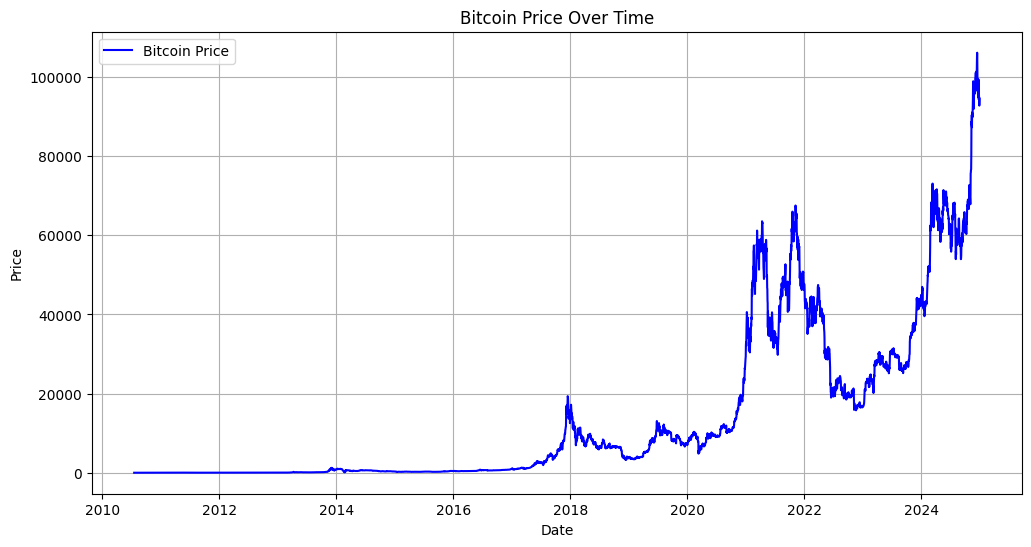

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data['Date'], bitcoin_data['Price'], label='Bitcoin Price', color='blue')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Graphing Bitcoin Halving events

When Is the Next Bitcoin Halving?

- Nov. 28, 2012, to 25 bitcoins.

- July 9, 2016, to 12.5 bitcoins.

- May 11, 2020, to 6.25 bitcoins.

- April 19, 2024, to 3.125 bitcoins.

![Bitcoin Halving: What It Is and Why It Matters for Crypto Investors](images/bitcoin_halving.webp)

[Bitcoin Halving: What It Is and Why It Matters for Crypto Investors](https://www.investopedia.com/bitcoin-halving-4843769)

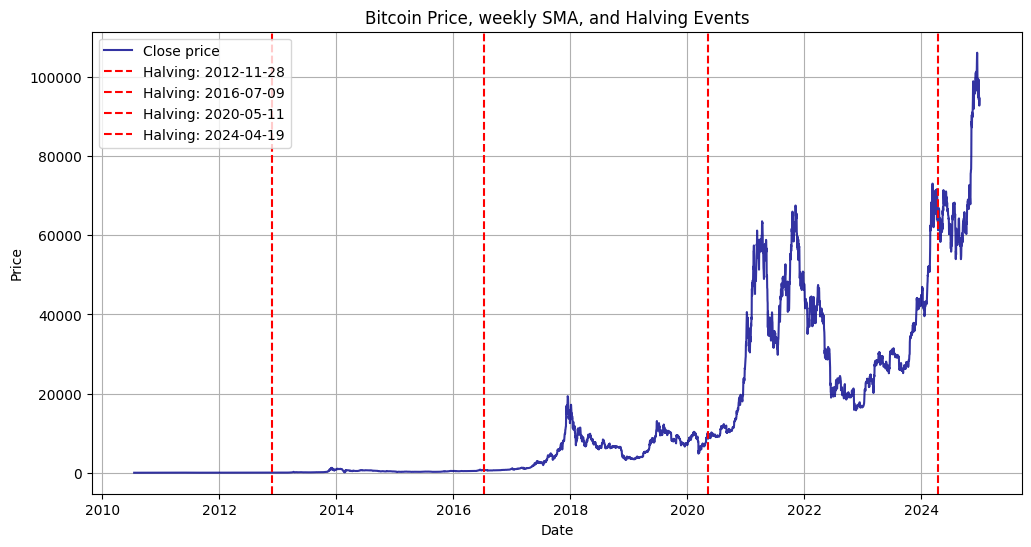

In [7]:
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-19'])
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)

for halving_date in halving_dates:
    plt.axvline(x=halving_date, color='red', linestyle='--', label=f'Halving: {halving_date.strftime("%Y-%m-%d")}')
plt.title('Bitcoin Price, weekly SMA, and Halving Events')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [8]:
bitcoin_data['year'] = bitcoin_data['Date'].dt.year
bitcoin_data['month'] = bitcoin_data['Date'].dt.month
bitcoin_data['day'] = bitcoin_data['Date'].dt.day

bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Average,year,month,day
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1,2010,7,18
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1,2010,7,19
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1,2010,7,20
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1,2010,7,21
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1,2010,7,22


In [9]:
bitcoin_data.drop(columns=['Vol.', 'Change %'], inplace=True)
bitcoin_data.head()

,Date,Price,Open,High,Low,Average,year,month,day
0,2010-07-18,0.1,0.0,0.1,0.1,0.1,2010,7,18
1,2010-07-19,0.1,0.1,0.1,0.1,0.1,2010,7,19
2,2010-07-20,0.1,0.1,0.1,0.1,0.1,2010,7,20
3,2010-07-21,0.1,0.1,0.1,0.1,0.1,2010,7,21
4,2010-07-22,0.1,0.1,0.1,0.1,0.1,2010,7,22


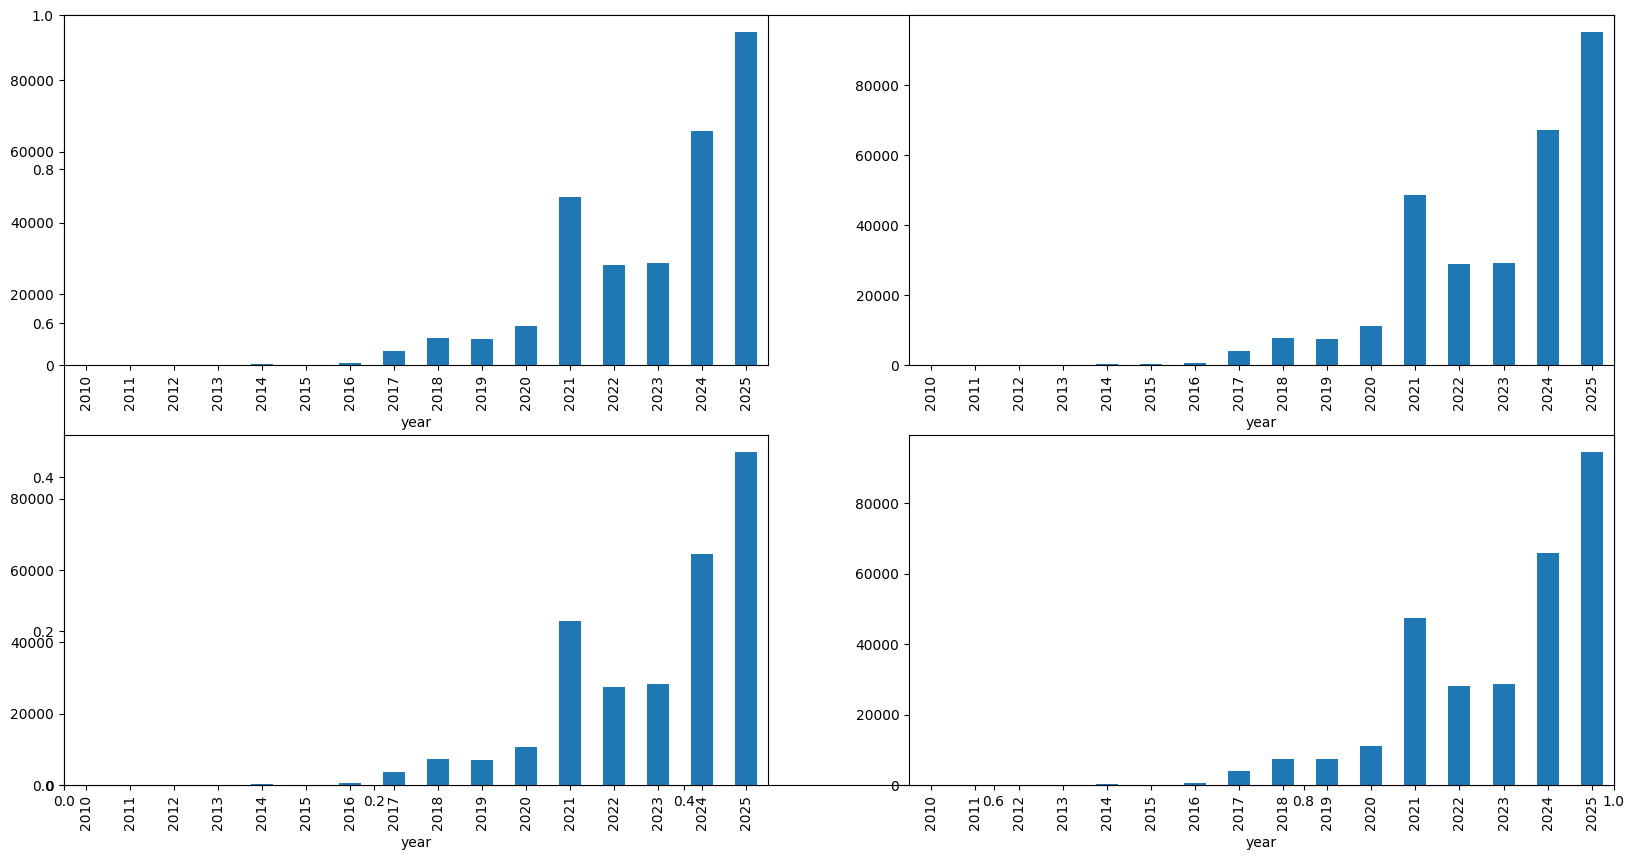

In [11]:
data_grouped = bitcoin_data.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Price']):
    plt.subplot(2, 2, i + 1)
    data_grouped[col].plot.bar()
plt.show()

<span style="font-size: 32px; font-weight: bold;">!!!!!!!!!!!!! From now on we are only using data from 2016 onwards !!!!!!!!!!!!!</span>


In [10]:
bitcoin_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Average', 'year', 'month',
       'day'],
      dtype='object')

In [10]:
columns_to_drop = ['Open', 'High', 'Low', 'Average', 'year', 'month', 'day']
bitcoin = bitcoin_data.drop(columns=columns_to_drop)
bitcoin = bitcoin[bitcoin['Date'] >= '2016-01-01']
bitcoin = bitcoin.set_index('Date')
bitcoin

,Price
Date,
2016-01-01,434.0
2016-01-02,433.7
2016-01-03,430.7
2016-01-04,433.3
2016-01-05,431.2
...,...
2024-12-28,95284.5
2024-12-29,93716.3
2024-12-30,92779.8


#### Stationarity check - Augmented Dickey–Fuller test and seasonality checks

In [14]:
adf_test = adfuller(bitcoin['Price'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: -0.029257087001064667
p-value: 0.9560446238021381
Critical values: {'1%': np.float64(-3.4323581184837426), '5%': np.float64(-2.862427266935068), '10%': np.float64(-2.5672423111140947)}
Fail to reject the null hypothesis - series is non-stationary


#### Why Create `Close_Diff`, `Close_Log`, and `Close_Log_Diff` columns?

When analyzing and modeling non-stationary time series data, such as Bitcoin prices, it is important to transform the data into a stationary form. Stationarity means that the statistical properties of the series (mean, variance) do not change over time, which is a key assumption for many time series models. We create the following three columns to address this:

1. `Close_Diff` (Differencing)
- **Purpose**: To stabilize the mean of the series by removing trends.
- **Explanation**: Differencing subtracts each data point from the previous one, helping to eliminate trends and making the series stationary. This is essential for models that require constant mean and variance over time.

2. `Close_Log` (Logging)
- **Purpose**: To stabilize the variance of the series.
- **Explanation**: Logging reduces the impact of large fluctuations by compressing the scale of the data. This is especially useful when the series exhibits exponential growth or large spikes, as it makes the data more consistent and easier to analyze.

3. `Close_Log_Diff` (Logging followed by Differencing)
- **Purpose**: To handle both non-stationary mean and variance simultaneously.
- **Explanation**: Logging is applied first to stabilize the variance, followed by differencing to stabilize the mean. This combination ensures the series meets the stationarity requirements, making it suitable for decomposition and predictive modeling.

Importance of These Transformations
- **Stationarity Requirement**: Many time series models, such as ARIMA, assume that the data is stationary. These transformations help meet that requirement, ensuring the models can accurately capture and predict patterns in the data.
- **Component Separation**: By transforming the series, we can more effectively separate the trend, seasonal, and residual components, leading to a clearer understanding of the underlying patterns.
- **Improved Model Accuracy**: Stationary series often result in more reliable and accurate models, as they align better with the assumptions of common time series analysis techniques.

#### Creating new columns

In [11]:
bitcoin['Close_Diff'] = bitcoin['Price'].diff()
bitcoin['Close_Log'] = np.log(bitcoin['Price'])
bitcoin['Close_Log_Diff'] = bitcoin['Close_Log'].diff()

In [16]:
bitcoin.head()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-01,434.0,NaN,6.073045,NaN
2016-01-02,433.7,-0.3,6.072353,-0.000691
2016-01-03,430.7,-3.0,6.065412,-0.006941
2016-01-04,433.3,2.6,6.071430,0.006019
2016-01-05,431.2,-2.1,6.066572,-0.004858


Drop the NaN values created by differencing

In [12]:
bitcoin.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)
bitcoin.head()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691
2016-01-03,430.7,-3.0,6.065412,-0.006941
2016-01-04,433.3,2.6,6.071430,0.006019
2016-01-05,431.2,-2.1,6.066572,-0.004858
2016-01-06,430.8,-0.4,6.065644,-0.000928


In [18]:
bitcoin.tail()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2024-12-28,95284.5,1008.6,11.464622,0.010642
2024-12-29,93716.3,-1568.2,11.448027,-0.016595
2024-12-30,92779.8,-936.5,11.437984,-0.010043
2024-12-31,93557.2,777.4,11.446328,0.008344
2025-01-01,94560.2,1003.0,11.456992,0.010664


In [14]:
series_list = {
    'Close_Diff': bitcoin['Close_Diff'],
    'Close_Log': bitcoin['Close_Log'],
    'Close_Log_Diff': bitcoin['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 2.3136336478386594e-15
Close_Log is non-stationary, with p-value: 0.4834741731268842
Close_Log_Diff is stationary, with p-value: 0.0


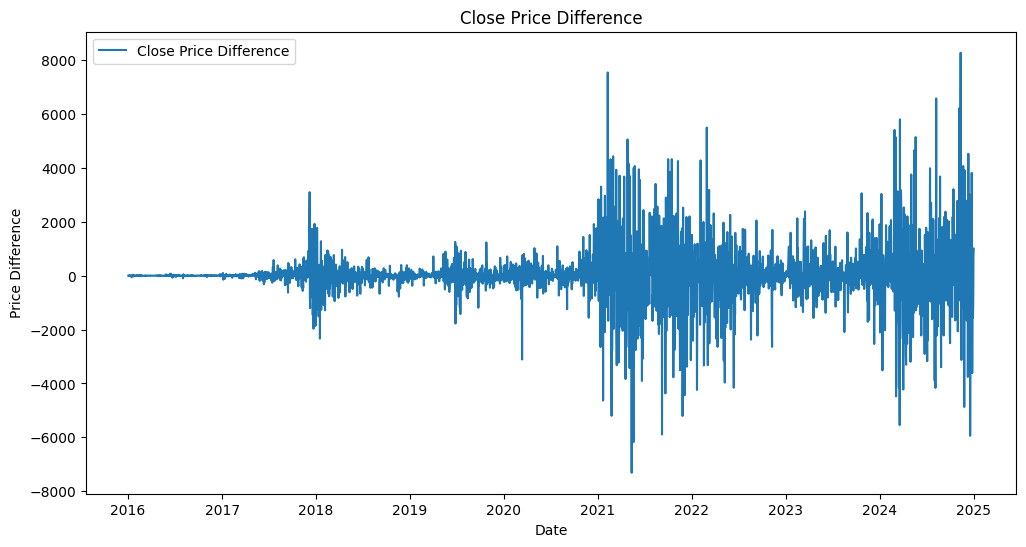

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Diff'], label='Close Price Difference')
plt.title('Close Price Difference')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

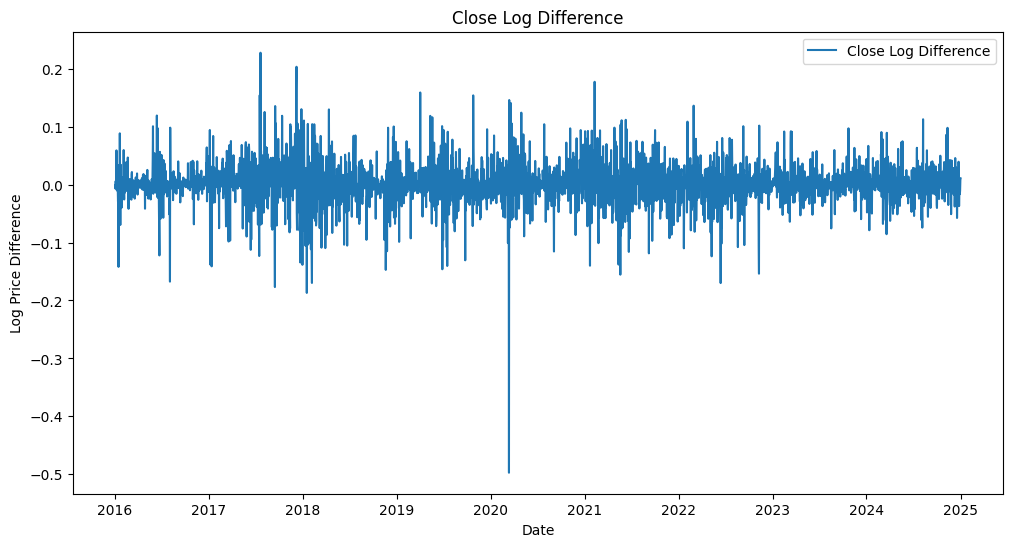

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log_Diff'], label='Close Log Difference')
plt.title('Close Log Difference')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')
plt.legend()
plt.show()

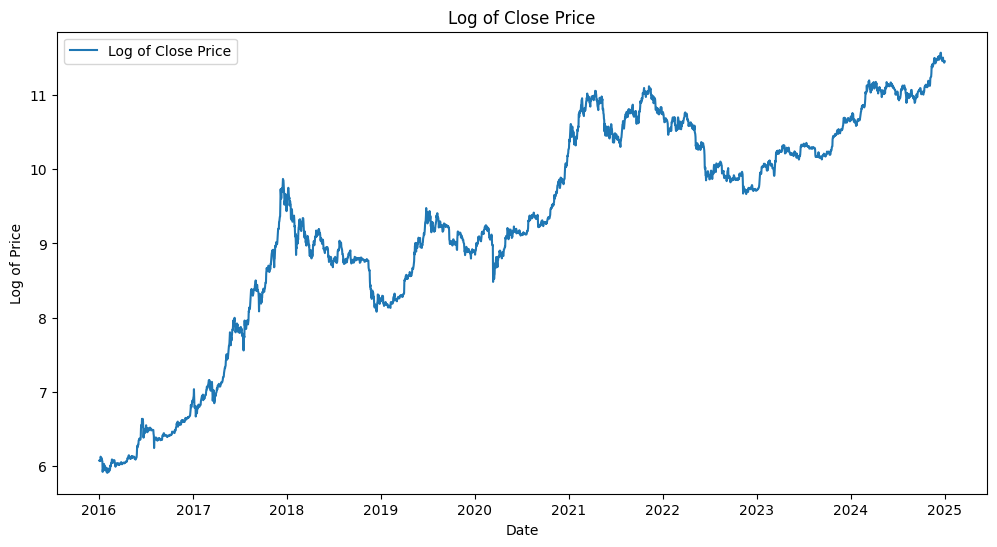

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

#### Plotting frequency

In [13]:
df_monthly = bitcoin.resample('ME').mean()
df_annual = bitcoin.resample('YE').mean()
df_quarterly = bitcoin.resample('QE').mean()

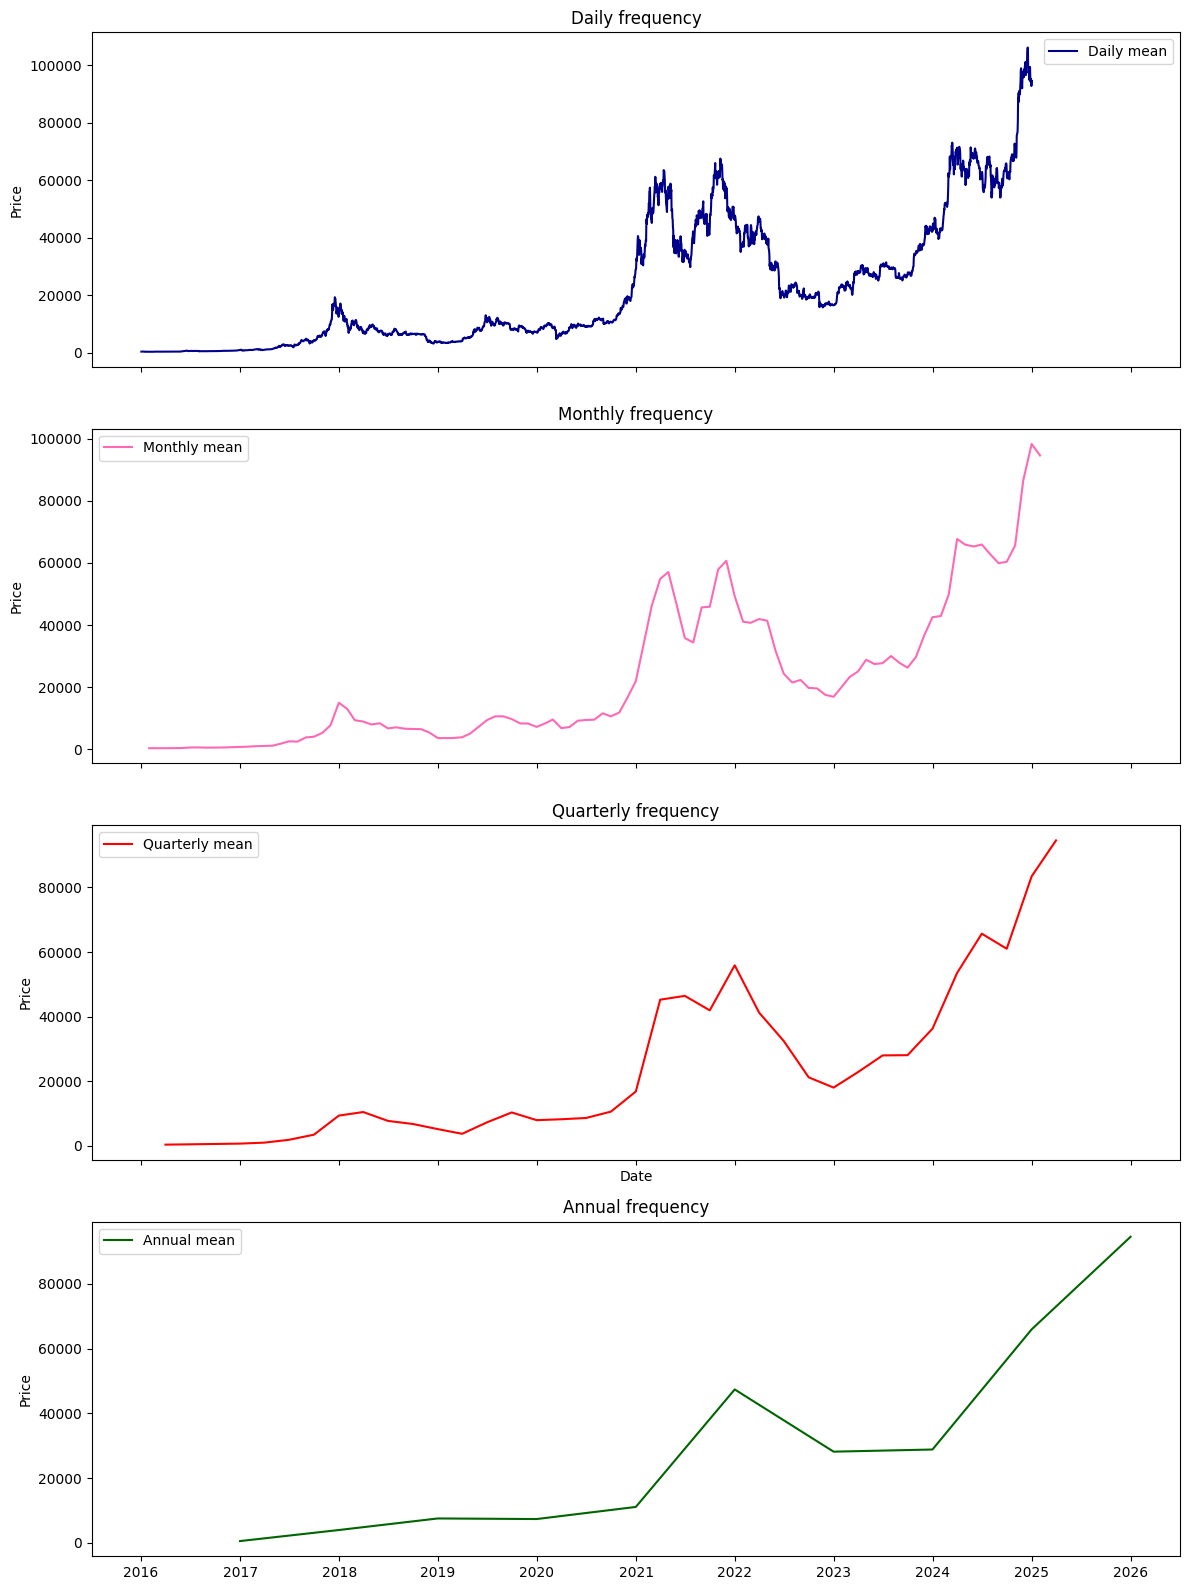

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
axs[0].plot(bitcoin.index, bitcoin['Price'], label='Daily mean', color='darkblue')
axs[0].set_title('Daily frequency')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df_monthly.index, df_monthly['Price'], label='Monthly mean', color='hotpink')
axs[1].set_title('Monthly frequency')
axs[1].set_ylabel('Price')
axs[1].legend()

axs[2].plot(df_quarterly.index, df_quarterly['Price'], label='Quarterly mean', color='red')
axs[2].set_title('Quarterly frequency')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()

axs[3].plot(df_annual.index, df_annual['Price'], label='Annual mean', color='darkgreen')
axs[3].set_title('Annual frequency')
axs[3].set_ylabel('Price')
axs[3].legend()

plt.tight_layout()
plt.show()

#### Moving Average

We are using it to smooth out short-term fluctuations and highlight longer-term trends or cycles. By calculating the average of the last 30 or 7 days, we can filter out noise and gain better insights into the overall direction of the price movement.

**7-day moving average:** This is a short-term smoothing technique that captures more immediate trends. It closely follows the original data, reacting quickly to recent price changes.

**30-day moving average:** This longer-term moving average smooths out the data even further, providing a clearer view of the general trend over a month. It is less sensitive to short-term volatility, making it particularly useful for identifying long-term trends or patterns.

In [14]:
bitcoin['SMA_7'] = bitcoin['Price'].rolling(window=7).mean()
bitcoin_data['SMA_7'] = bitcoin_data['Price'].rolling(window=7).mean()
bitcoin.head(15)


,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7
Date,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN
2016-01-07,457.0,26.2,6.124683,0.059039,NaN
2016-01-08,452.9,-4.1,6.115671,-0.009012,438.514286
2016-01-09,448.3,-4.6,6.105463,-0.010209,440.600000
2016-01-10,446.2,-2.1,6.100767,-0.004695,442.814286


In [26]:
bitcoin.tail()

,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7
Date,,,,,
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714
2024-12-31,93557.2,777.4,11.446328,0.008344,94968.957143
2025-01-01,94560.2,1003.0,11.456992,0.010664,94278.800000


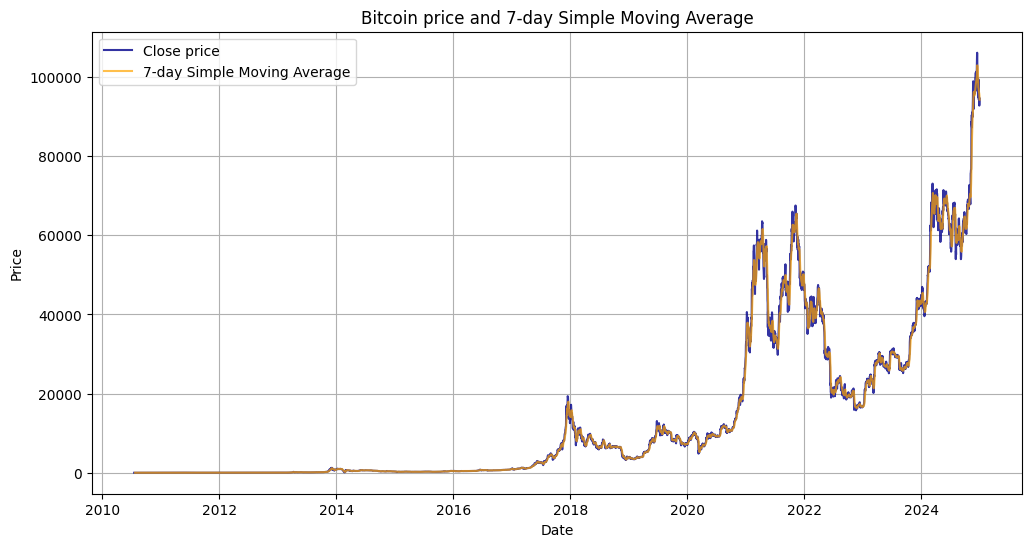

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin_data["Date"], bitcoin_data['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and 7-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

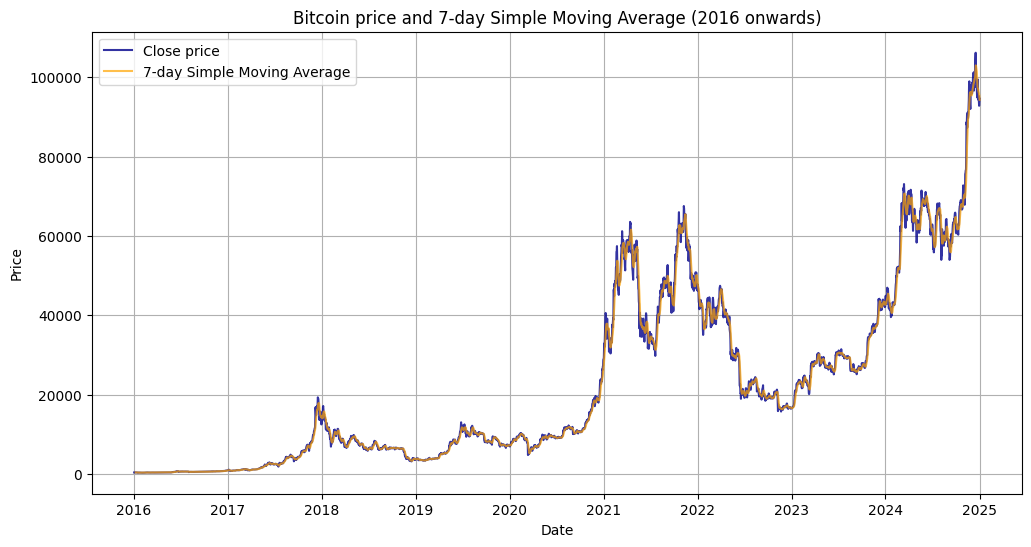

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and 7-day Simple Moving Average (2016 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

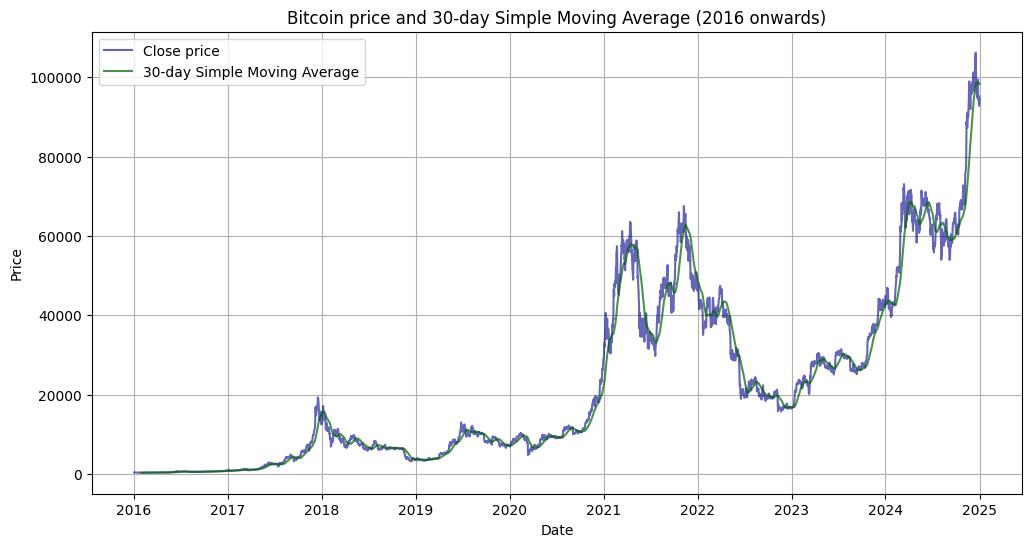

In [15]:
bitcoin['SMA_30'] = bitcoin['Price'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin["Price"], label='Close price', color='darkblue', alpha=0.6)
plt.plot(bitcoin['SMA_30'], label='30-day Simple Moving Average', color='darkgreen', alpha=0.7)
plt.title('Bitcoin price and 30-day Simple Moving Average (2016 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Plotting decompositions

1. **Original Time Series: Multiplicative Decomposition**
- **Reason**: The original series is non-stationary (due to trends and high volatility). 
- **Why Multiplicative?**: Multiplicative decomposition is used when seasonality scales with the level of the series. Bitcoin's volatility and trends make this model suitable.

2. **Differenced Time Series: Additive Decomposition**
- **Reason**: Differencing removes the trend, making the series stationary with constant mean and variance.
- **Why Additive?**: Additive decomposition assumes the series has constant variance, which fits the differenced series after it’s been made stationary.

3. **Logged Time Series: Additive Decomposition**
- **Reason**: Logging stabilizes variance but does not always make the series stationary.
- **Why Additive?**: Even though the series is still non-stationary, logging helps reduce fluctuations, and additive decomposition fits better for the stationary-like behavior of the logged series.

4. **Logged and Differenced Time Series: Additive Decomposition**
- **Reason**: Logging followed by differencing removes both trends and stabilizes the variance, making the series stationary.
- **Why Additive?**: Since the series is now stationary, additive decomposition works best as the seasonal and residual components are now stable.


In [20]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    fig.patch.set_facecolor(plot_color)
    plt.show()

##### Yearly

In [31]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    for ax in fig.axes:
        for line in ax.get_lines():
            line.set_color(plot_color)
    plt.show()

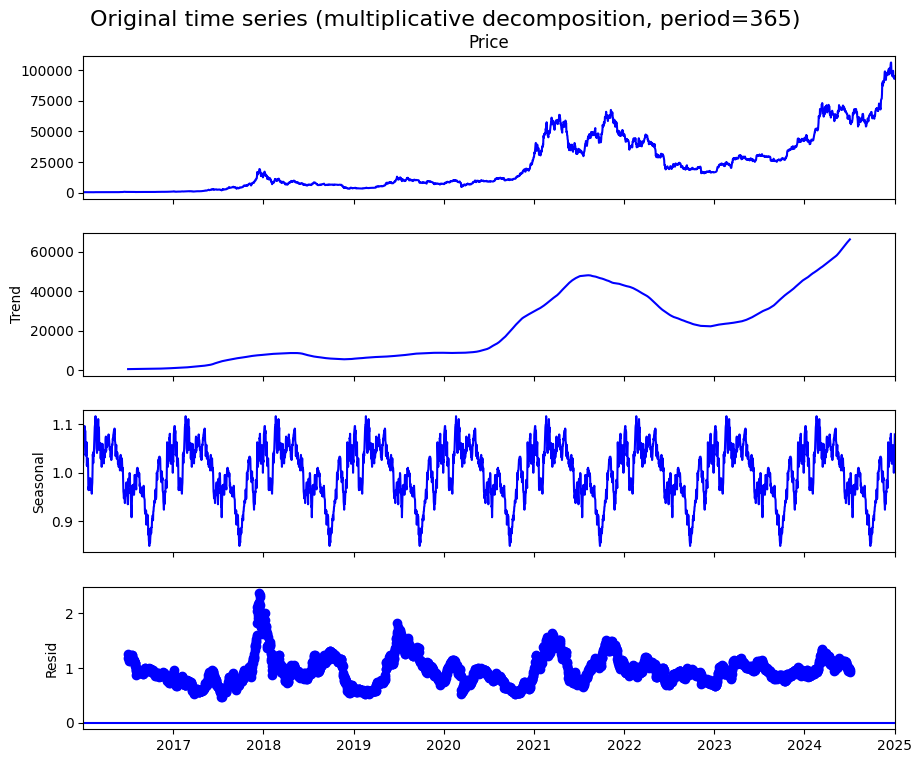

In [654]:
plot_decomposition(bitcoin['Price'], model='multiplicative', period=365, title="Original time series (multiplicative decomposition, period=365)", plot_color='blue')

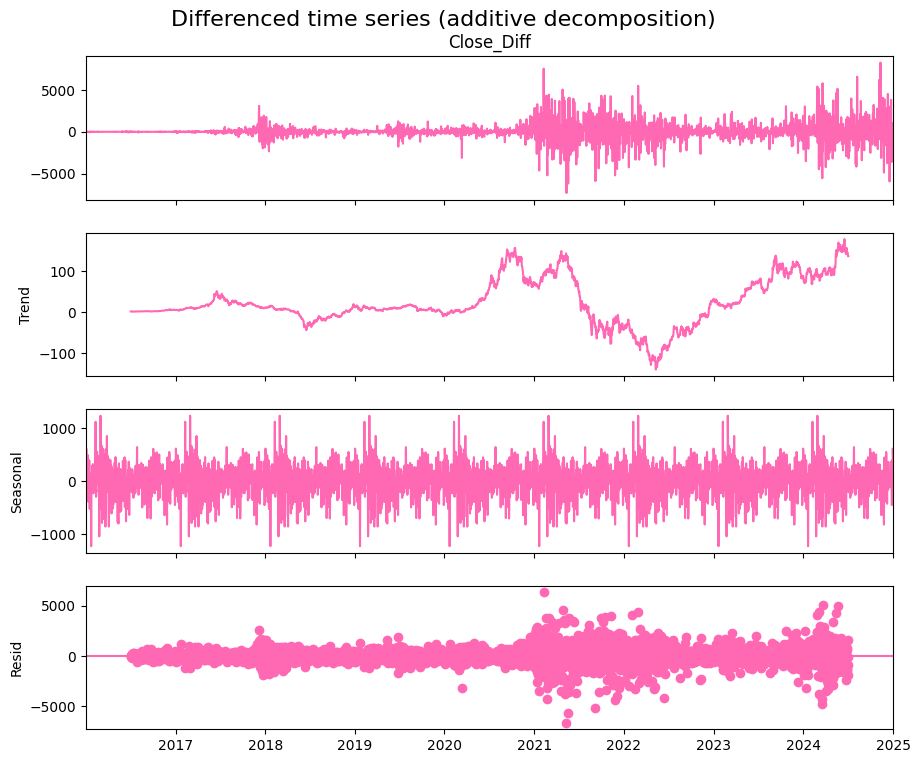

In [32]:
plot_decomposition(bitcoin['Close_Diff'], model='additive',period=365, plot_color='hotpink', title="Differenced time series (additive decomposition)")


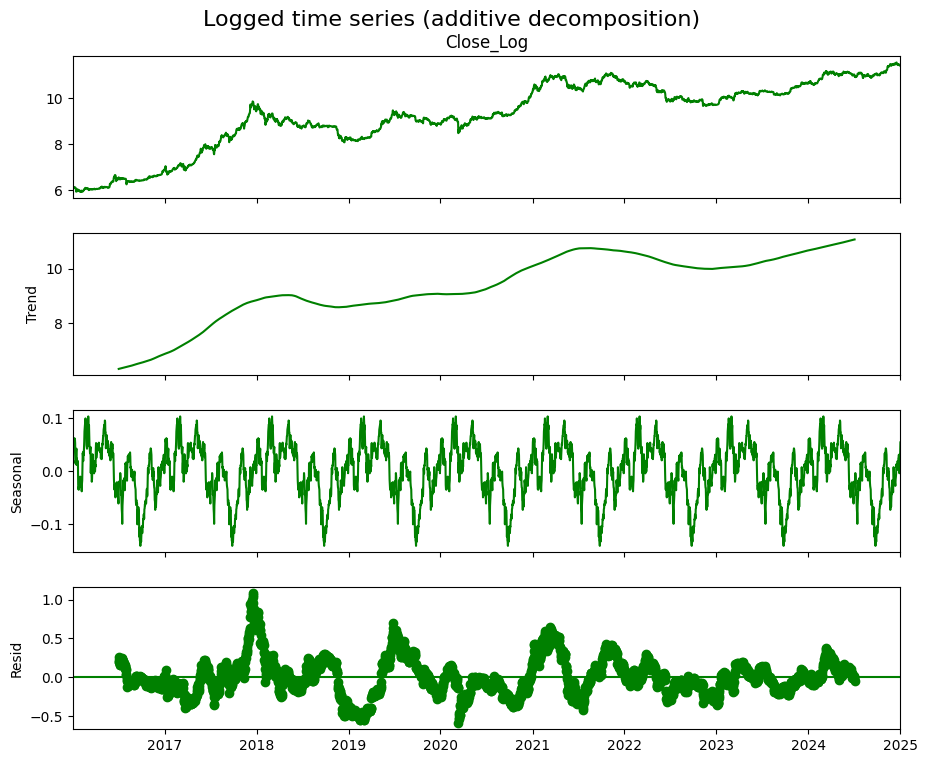

In [33]:
plot_decomposition(bitcoin['Close_Log'], model='additive', period=365, title="Logged time series (additive decomposition)", plot_color='green')

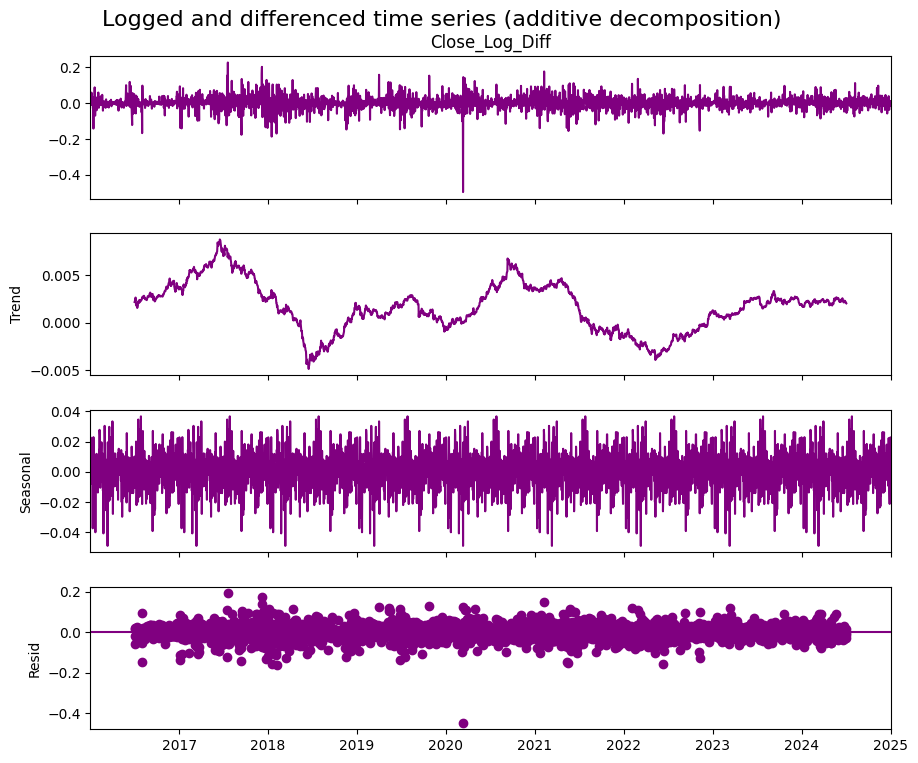

In [34]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', period=365, title="Logged and differenced time series (additive decomposition)", plot_color='purple')

##### Quarterly

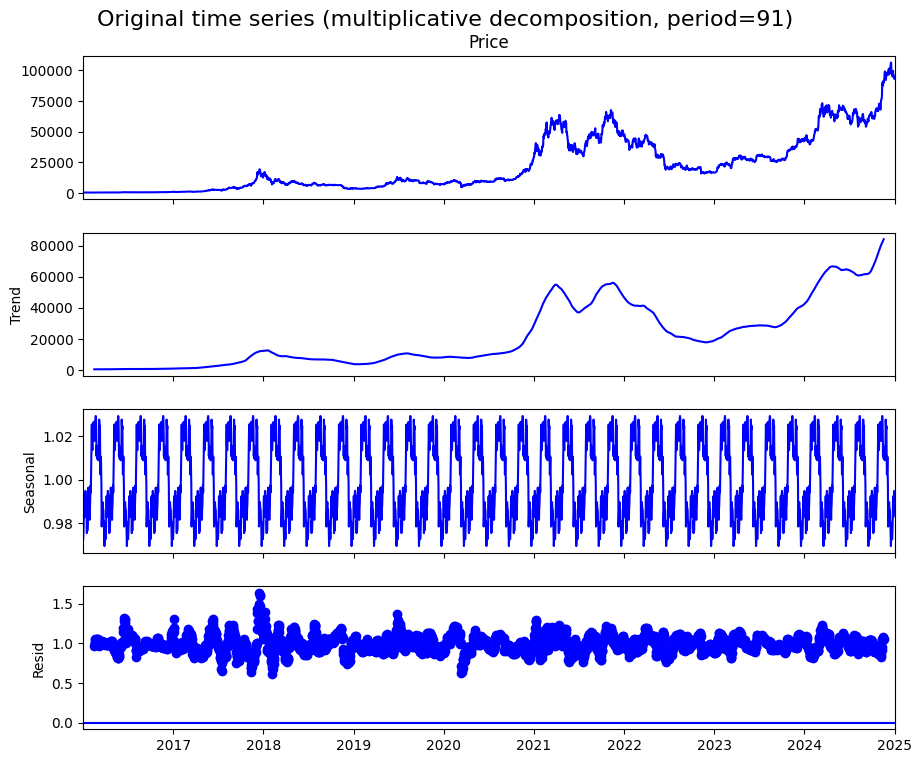

In [35]:
plot_decomposition(bitcoin['Price'], model='multiplicative', period=91, title="Original time series (multiplicative decomposition, period=91)", plot_color='blue')

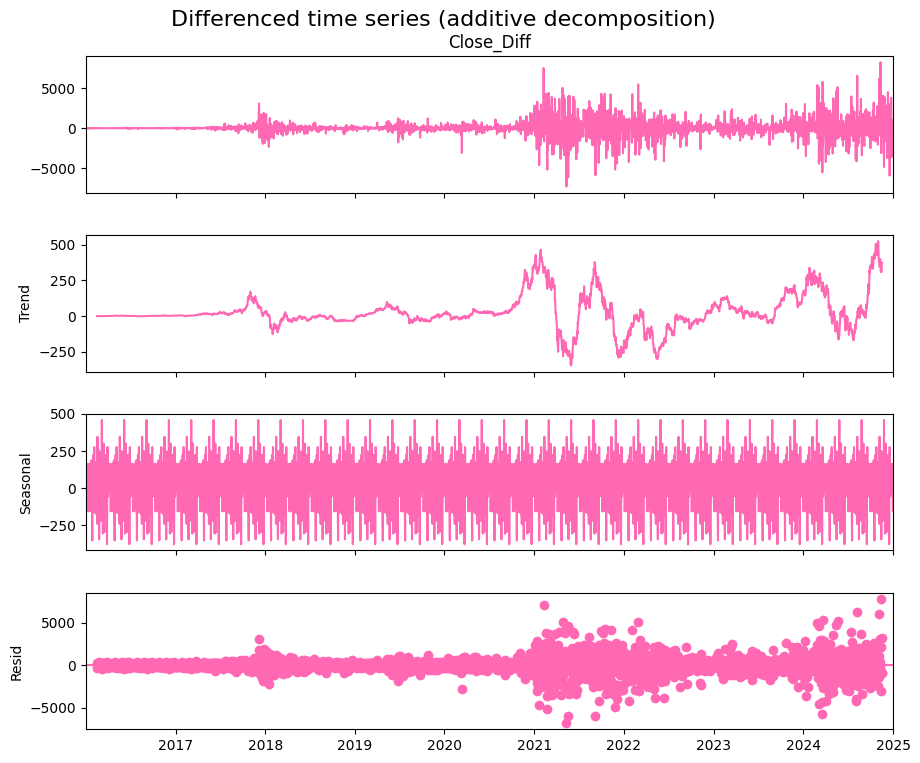

In [36]:
plot_decomposition(bitcoin['Close_Diff'], model='additive', period=91, title="Differenced time series (additive decomposition)", plot_color='hotpink')

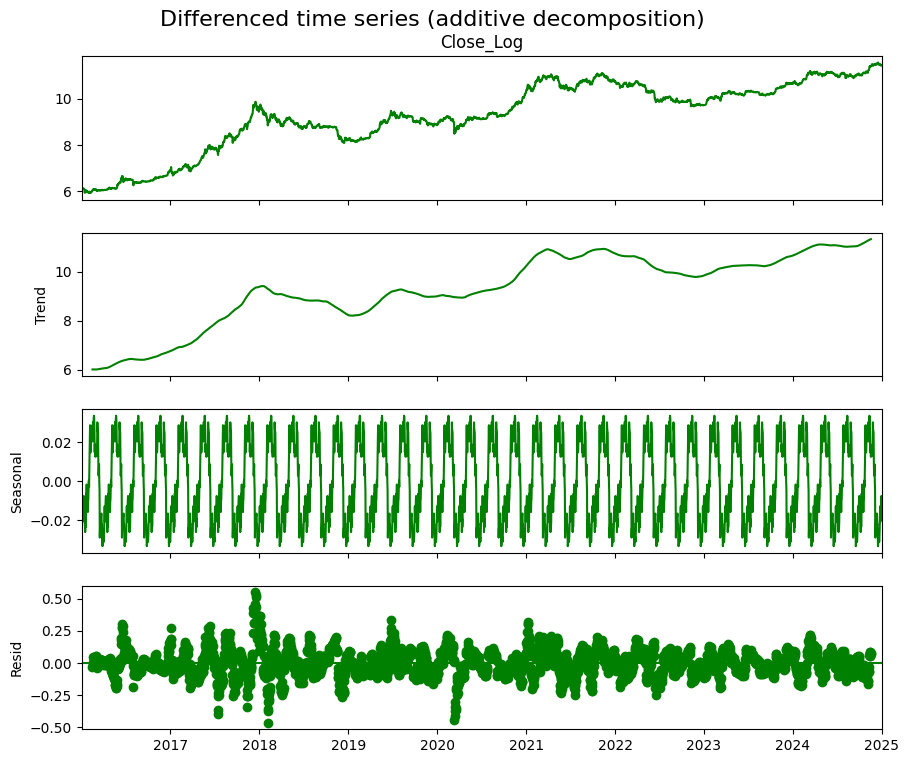

In [37]:
plot_decomposition(bitcoin['Close_Log'], model='additive', period=91, title="Differenced time series (additive decomposition)", plot_color='green')

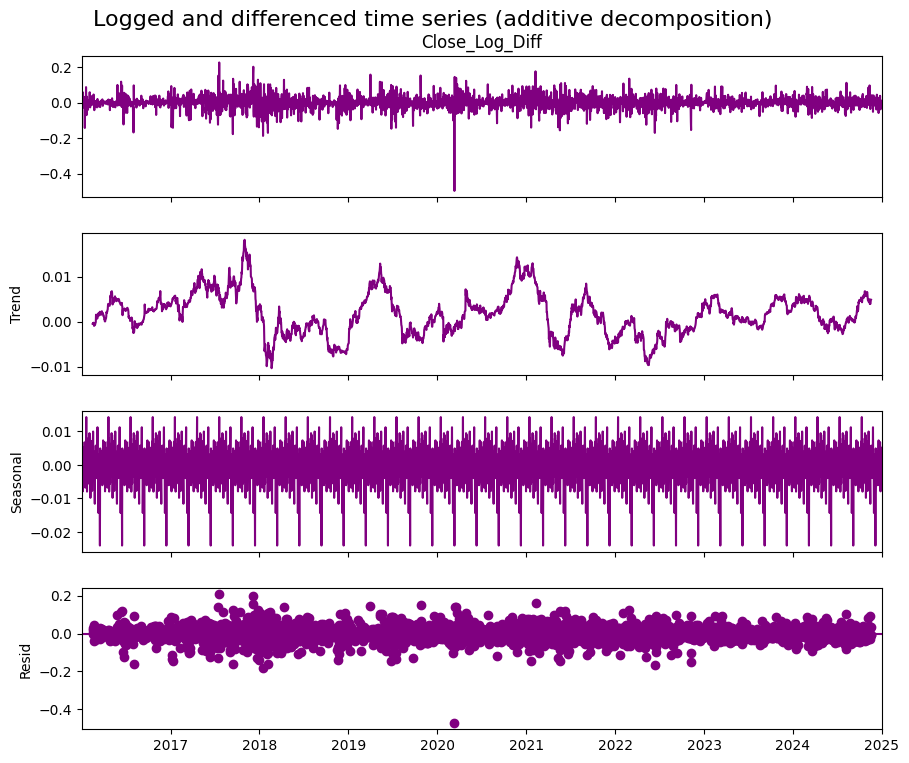

In [38]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', period=91, title="Logged and differenced time series (additive decomposition)", plot_color='purple')


##### 4-year periods

In [39]:
halving_periods = [
    {'start': '2016-07-09', 'end': '2020-05-11'},  # From first to second halving
    {'start': '2020-05-11', 'end': '2024-04-19'},  # From second to third halving
]

halving_data = []
for period in halving_periods:
    segment = bitcoin[(bitcoin.index >= period['start']) & (bitcoin.index <= period['end'])]
    halving_data.append(segment)

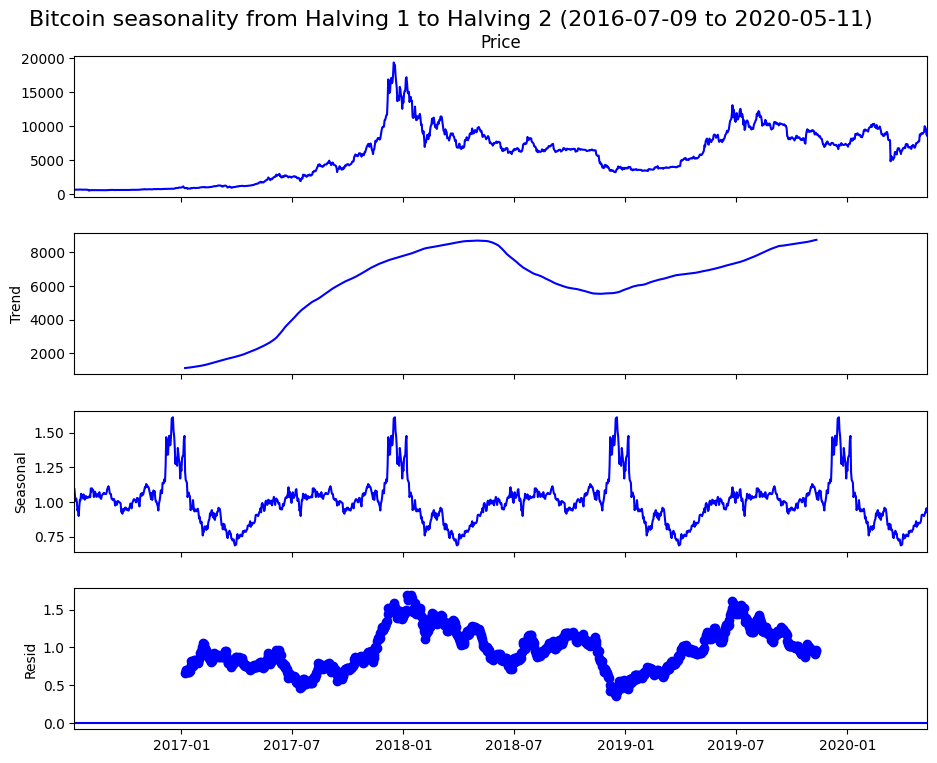

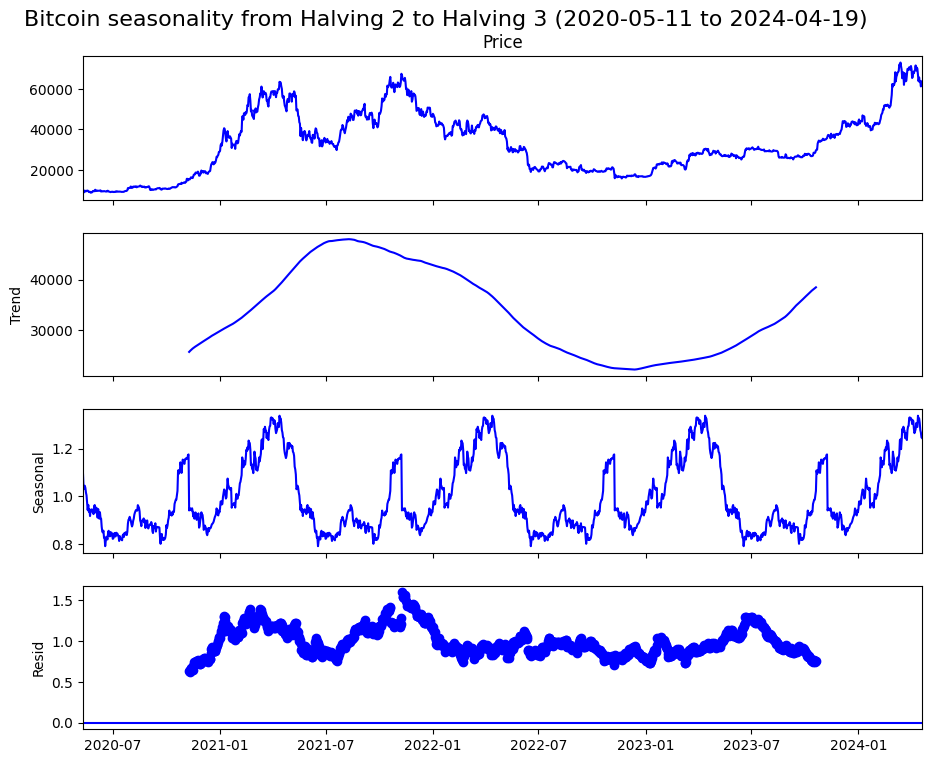

In [40]:
def plot_seasonality_for_period(data, title, period=365, plot_color='blue'):
    plot_decomposition(data['Price'], model='multiplicative', period=period, title=title, plot_color=plot_color)

for i, segment in enumerate(halving_data):
    title = f"Bitcoin seasonality from Halving {i+1} to Halving {i+2} ({segment.index[0].strftime('%Y-%m-%d')} to {segment.index[-1].strftime('%Y-%m-%d')})"
    plot_seasonality_for_period(segment, title=title, plot_color='blue')

#### ACF PACF

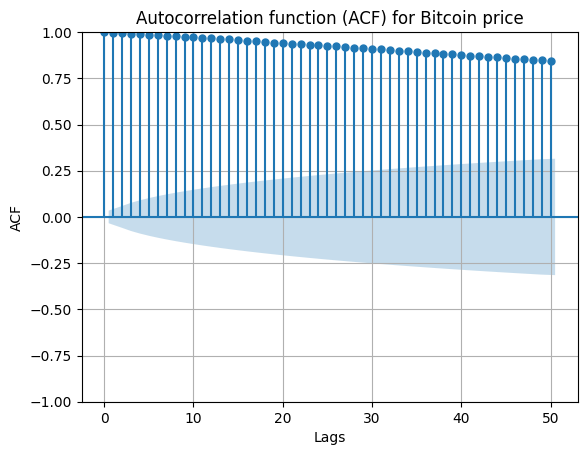

In [41]:
plot_acf(bitcoin['Price'], lags=50)
plt.title('Autocorrelation function (ACF) for Bitcoin price')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

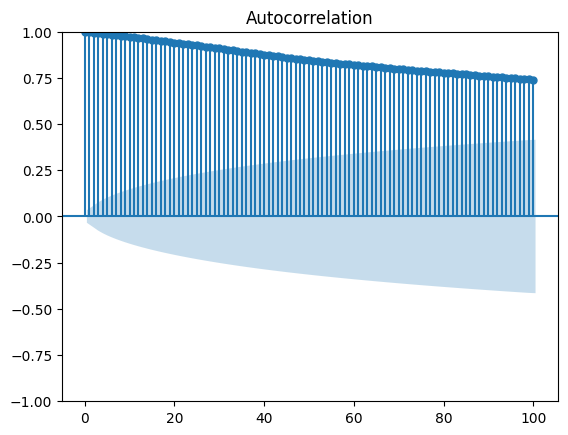

In [42]:
plot_acf(bitcoin['Price'], lags=100)
plt.show()

The Autocorrelation plot for the data is:


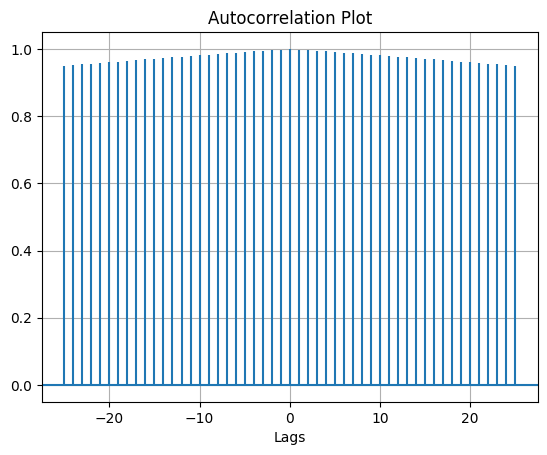

In [43]:
plt.title("Autocorrelation Plot") 
plt.xlabel("Lags") 
plt.acorr(bitcoin["Price"], maxlags = 25) 
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show() 

ACF plots suggest that it doesn't work well for the bitcoin data. The autocorrelations are not decaying over time. Data is non-stationary, that is why, the ACF gives misleading results.








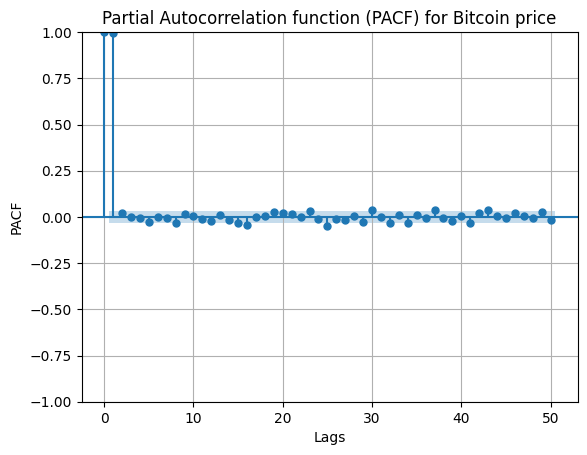

In [44]:
plot_pacf(bitcoin['Price'], lags=50)
plt.title('Partial Autocorrelation function (PACF) for Bitcoin price')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

PACF sharp drop after lag 1 suggests the series may be well represented by an AR(1) model, meaning that the series’ current value is largely dependent on its immediate previous value, and no higher lags are needed for prediction.
It indicates that after the first lag, higher-order correlations are weak or negligible, meaning the series is not influenced by past values beyond the most recent one.

#### Prophet

Prophet is a forecasting tool developed by Facebook that is particularly useful for time series data that exhibits patterns such as seasonality and trends. It provides a structured way to predict future prices, giving insight into potential price movements and the uncertainty around those predictions. It’s valuable for understanding both short-term forecasts and long-term trends.

It is specifically designed to handle missing data, outliers, seasonality and trends (it models long-term trends that can be linear or non-linear)

In [17]:
df = bitcoin[['Price']].reset_index()
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

In [18]:
df

,ds,y
0,2016-01-02,433.7
1,2016-01-03,430.7
2,2016-01-04,433.3
3,2016-01-05,431.2
4,2016-01-06,430.8
...,...,...
3283,2024-12-28,95284.5
3284,2024-12-29,93716.3
3285,2024-12-30,92779.8
3286,2024-12-31,93557.2


In [19]:
df['ds'] = pd.to_datetime(df['ds'])
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 'yhat' represents the predicted values, 'yhat_lower' and 'yhat_upper' are the confidence intervals
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:47 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2016-01-02,-53.705306,-6343.239609,5990.366369
1,2016-01-03,-87.010155,-6334.326692,6224.617875
2,2016-01-04,-78.128458,-6591.640770,6296.782619
3,2016-01-05,-179.375532,-7094.153431,6185.376315
4,2016-01-06,-173.669986,-6734.232975,5807.891137
...,...,...,...,...
3313,2025-01-27,85890.016499,79116.414541,91993.849161
3314,2025-01-28,85989.799206,79479.349794,92462.472479
3315,2025-01-29,86220.767850,79677.068727,91871.293796
3316,2025-01-30,86300.755330,79854.847686,92642.646502


The forecasted values (yhat) represent the predicted Bitcoin prices for the next 30 days based on the historical data.

The confidence intervals (yhat_lower and yhat_upper) show the range within which the actual future prices are likely to fall, providing an uncertainty estimate around the prediction.

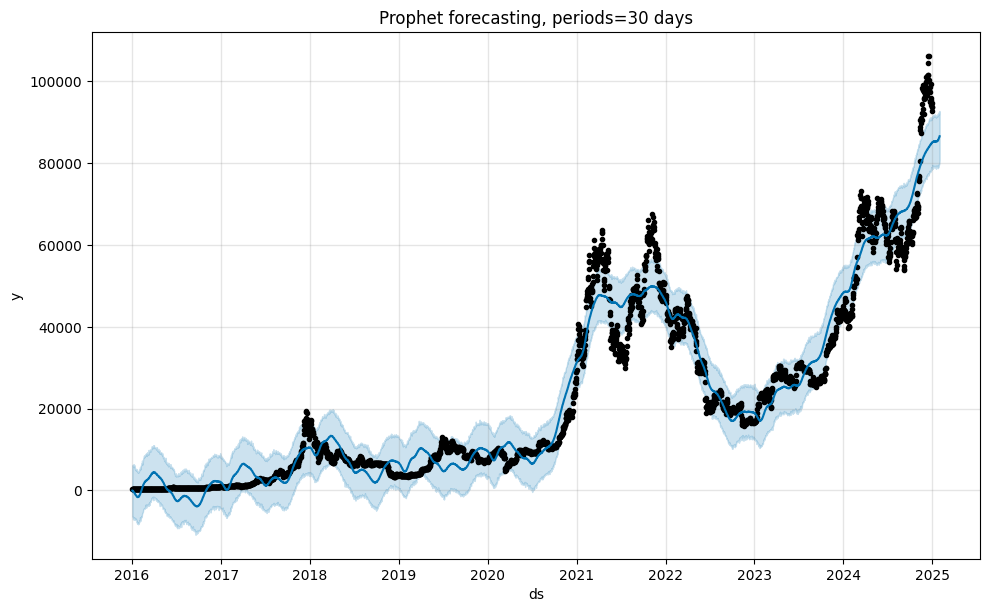

In [23]:
model.plot(forecast)
plt.title("Prophet forecasting, periods=30 days")
plt.show()

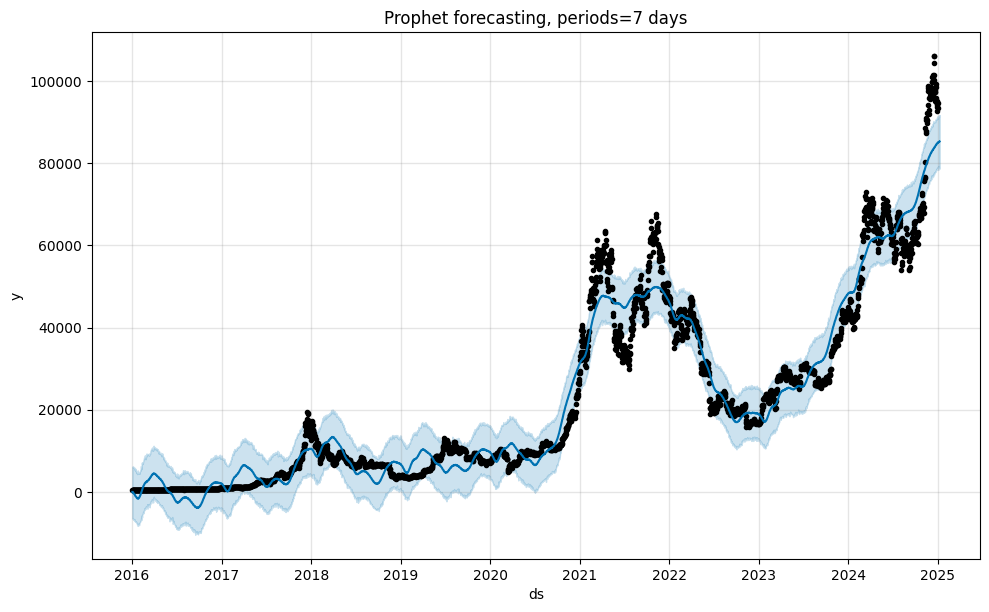

In [26]:
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

model.plot(forecast)
plt.title("Prophet forecasting, periods=7 days")
plt.show()

The forecast generated by the Prophet model appears smoother, as it effectively captures long-term trends and seasonal patterns. However, this smoothing is expected due to Prophet's assumption that the underlying time series follows consistent, predictable trends. While this approach works well for identifying overall directions and periodic fluctuations, it may not fully capture the more erratic short-term fluctuations in Bitcoin's price.

#### Holt-Winters model

When analyzing and modeling non-stationary time series data, such as Bitcoin prices, it is important to use methods that can handle both trend and seasonality in the data. The Holt-Winter model (also known as Triple Exponential Smoothing) is widely used because it accounts for these underlying components, making it particularly suitable for data with complex patterns.

In [27]:
df = bitcoin.copy()
df

,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,SMA_30
Date,,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN,NaN
...,...,...,...,...,...,...
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429,98661.200000
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571,98537.143333
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714,98416.280000


In [28]:
df.drop(columns=['Close_Diff', 'Close_Log', 'Close_Log_Diff', 'SMA_7', 'SMA_30'], inplace=True)
df.head()

,Price
Date,
2016-01-02,433.7
2016-01-03,430.7
2016-01-04,433.3
2016-01-05,431.2
2016-01-06,430.8


In [29]:
train_size = int(len(df) * 0.8)
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
hw_model = ExponentialSmoothing(df_train, seasonal='add', seasonal_periods=30, trend='add').fit()


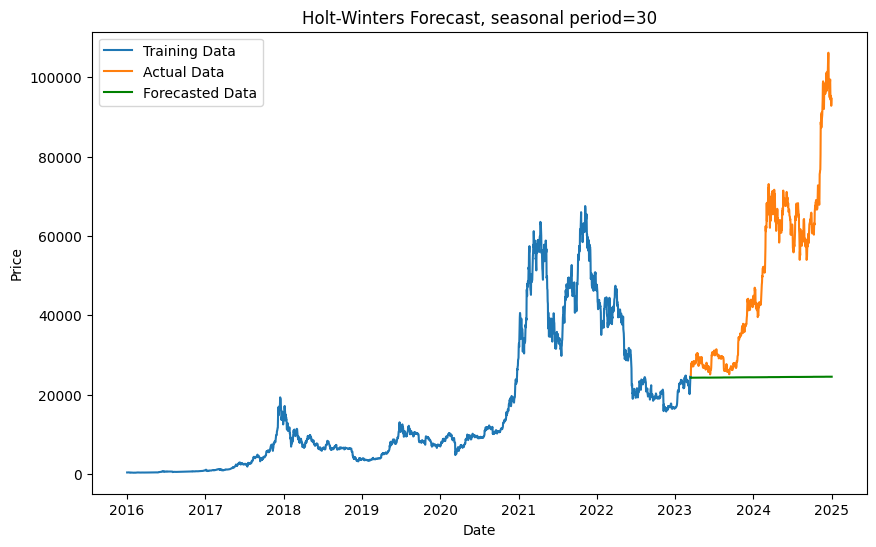

In [32]:
forecast = hw_model.forecast(steps=len(df_test))

plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train, label='Training Data')
plt.plot(df_test.index, df_test, label='Actual Data')
plt.plot(df_test.index, forecast, label='Forecasted Data', color='green')
plt.title('Holt-Winters Forecast, seasonal period=30')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
hw_model = ExponentialSmoothing(df_train, seasonal='add', seasonal_periods=7, trend='add').fit()

forecast = hw_model.forecast(steps=len(df_test))


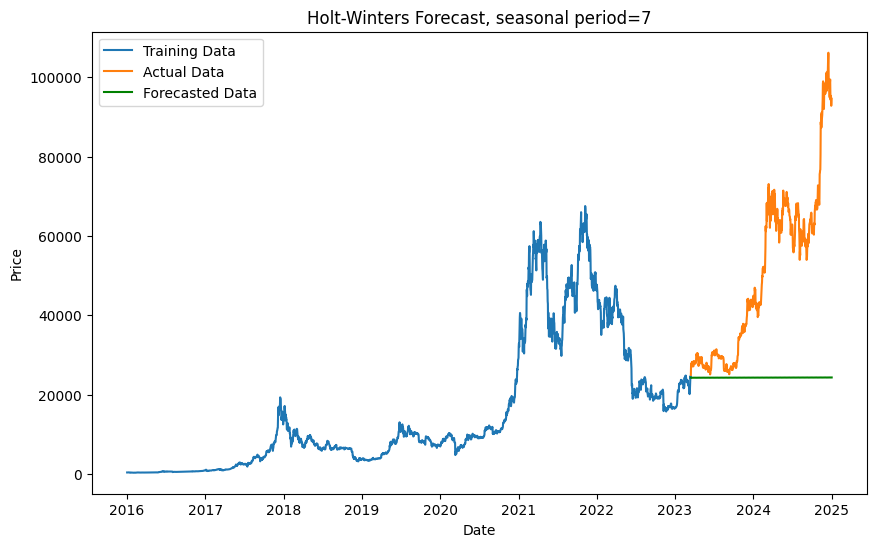

In [35]:

plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train, label='Training Data')
plt.plot(df_test.index, df_test, label='Actual Data')
plt.plot(df_test.index, forecast, label='Forecasted Data', color='green')
plt.title('Holt-Winters Forecast, seasonal period=7')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

The Holt-Winter model does not perform well with Bitcoin prices in this case, as it results in a straight-line forecast. This suggests that the model is unable to capture the high volatility and erratic nature of Bitcoin prices, which are well-suited for simpler trend and seasonality-based forecasting.

#### ARIMA

In [57]:
df_arima = bitcoin.copy()
df_arima

,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,SMA_30
Date,,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN,NaN
...,...,...,...,...,...,...
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429,98661.200000
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571,98537.143333
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714,98416.280000


In [58]:
train_size = int(len(df_arima) * 0.8)  
train, test = df_arima.iloc[:train_size], df_arima.iloc[train_size:]

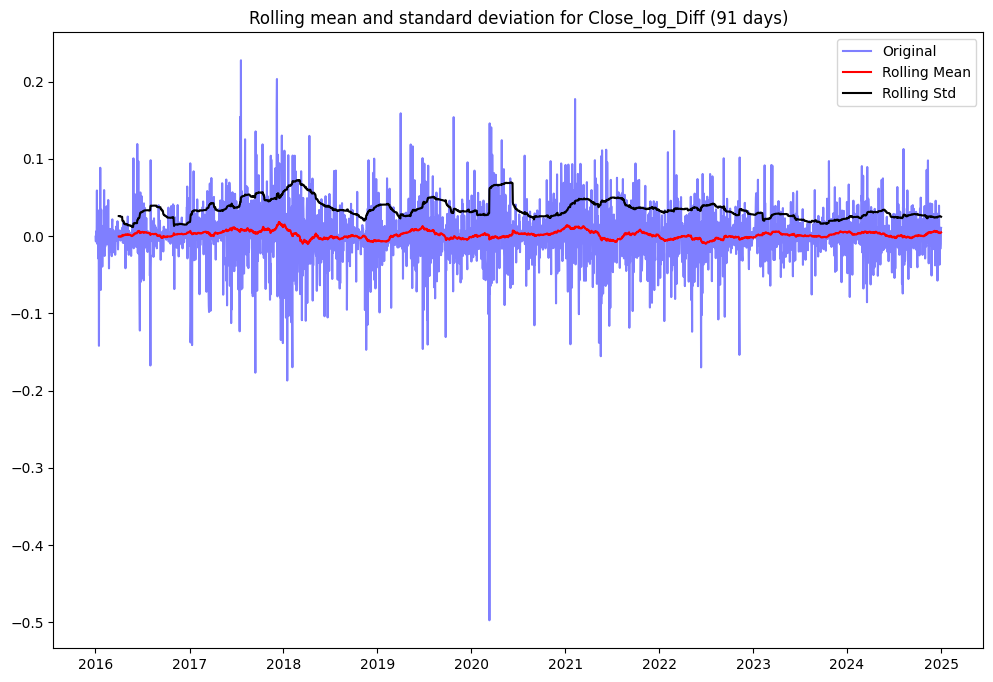

In [43]:
rolmean = df_arima['Close_Log_Diff'].rolling(91).mean()
rolstd = df_arima['Close_Log_Diff'].rolling(91).std()

plt.figure(figsize=(12,8))
orig = plt.plot(df_arima['Close_Log_Diff'], color = 'blue', label = 'Original', alpha=0.5)
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label= "Rolling Std")
plt.title("Rolling mean and standard deviation for Close_log_Diff (91 days)")
plt.legend(loc='best')
plt.show()

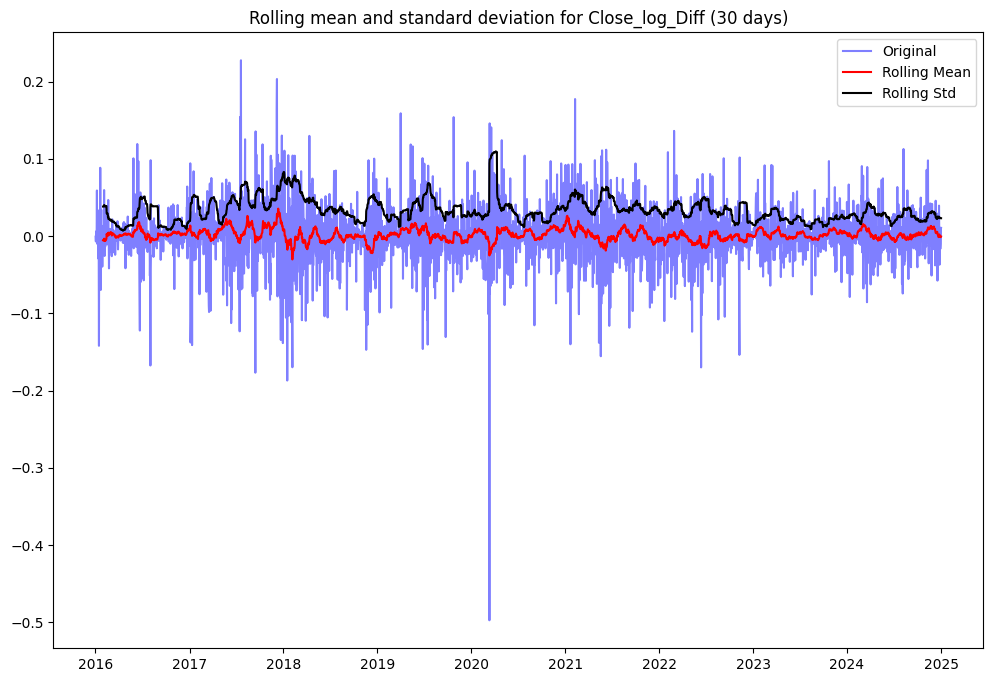

In [42]:
rolmean = df_arima['Close_Log_Diff'].rolling(30).mean()
rolstd = df_arima['Close_Log_Diff'].rolling(30).std()

plt.figure(figsize=(12,8))
orig = plt.plot(df_arima['Close_Log_Diff'], color = 'blue', label = 'Original', alpha=0.5)
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label= "Rolling Std")
plt.title("Rolling mean and standard deviation for Close_log_Diff (30 days)")
plt.legend(loc='best')
plt.show()

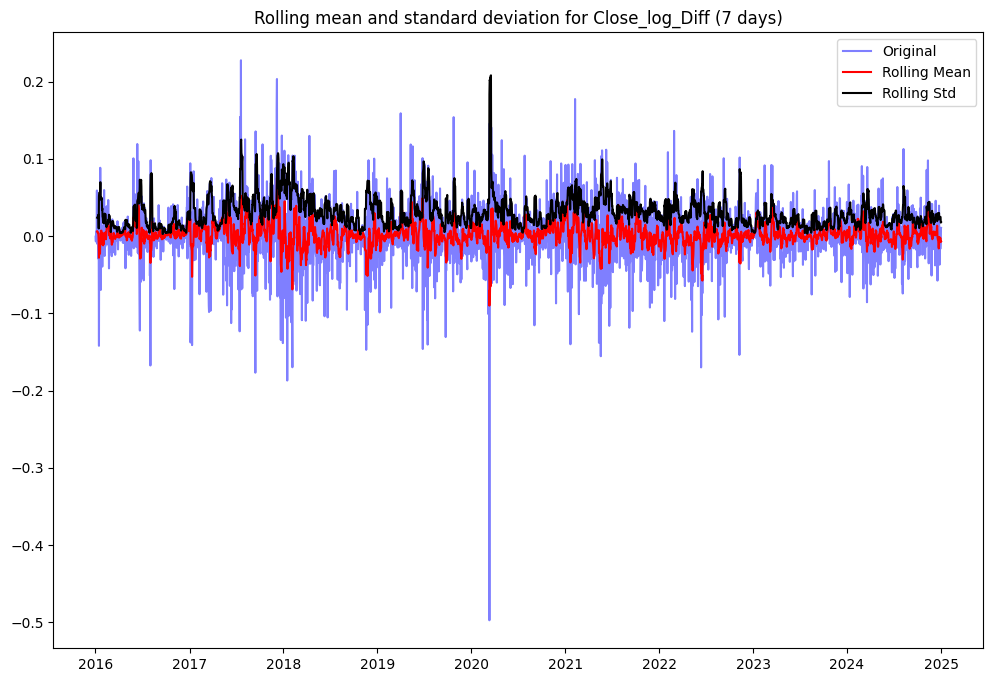

In [40]:
rolmean = df_arima['Close_Log_Diff'].rolling(7).mean()
rolstd = df_arima['Close_Log_Diff'].rolling(7).std()

plt.figure(figsize=(12,8))
orig = plt.plot(df_arima['Close_Log_Diff'], color = 'blue', label = 'Original', alpha=0.5)
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label= "Rolling Std")
plt.title("Rolling mean and standard deviation for Close_log_Diff (7 days)")
plt.legend(loc='best')
plt.show()

In [ ]:
#Finding the best Arima Model
p_values = [1, 2, 3]
q_values = [1, 2, 3]
d_values = [1, 2, 3]

best_aic = np.inf
best_bic = np.inf
best_model = None
best_p, best_q, best_d = None, None, None

for p in p_values:
    for q in q_values:
        for d in d_values:
            try:
                model = ARIMA(train["Price"], order=(p,d,q))
                model_fit = model.fit()
            
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_bic = model_fit.bic
                    best_model = model_fit
                    best_p, best_d, best_q = p, d, q

            except Exception as e:
                print(f"Error fitting ARIMA({p},{d},{q}): {e}")

In [21]:
print(f"Best Model: ARIMA({best_p},{best_d},{best_q})")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best Model: ARIMA(2,2,3)
AIC: 42995.61092959325
BIC: 43030.854799870875


In [ ]:
# Fit ARIMA model
model = ARIMA(train['Price'], order=(2, 2, 3))
model_fit = model.fit()
forecasts_arima = model_fit.forecast(steps=len(test))

In [60]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2630
Model:                 ARIMA(2, 2, 3)   Log Likelihood              -21491.805
Date:                Tue, 28 Jan 2025   AIC                          42995.611
Time:                        22:32:06   BIC                          43030.855
Sample:                    01-02-2016   HQIC                         43008.374
                         - 03-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9040      0.009   -221.701      0.000      -1.921      -1.887
ar.L2         -0.9747      0.009   -112.142      0.000      -0.992      -0.958
ma.L1          0.8835      0.013     70.181      0.000       0.859       0.908
ma.L2         -0.9318      0.008   -112.330      0.000      -0.948      -0.916
ma.L3         -0.9512      0.012    -78.001      0.000      -0.975      -0.927
sigma2      7.911e+05   9325.459     84.827      0.000    7.73e+05    8.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19973.74
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              17.93   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

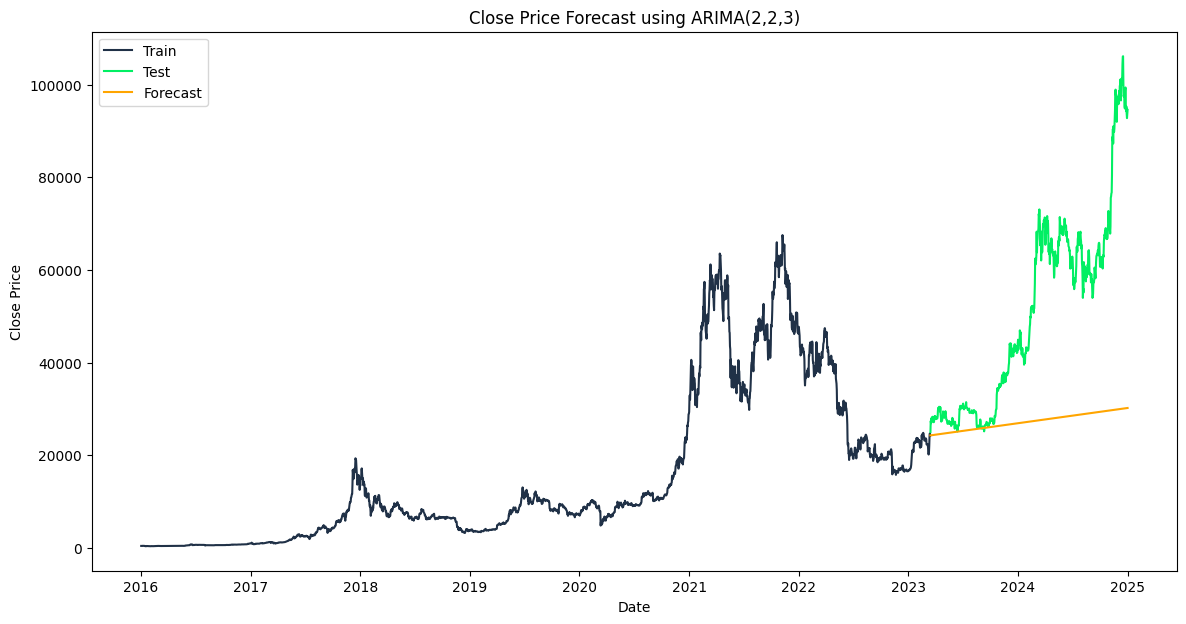

In [61]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Price"], label='Train', color='#203147')
plt.plot(test.index, test["Price"], label='Test', color='#01ef63')
plt.plot(test.index, forecasts_arima, label='Forecast', color='orange')
plt.title('Close Price Forecast using ARIMA(2,2,3)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [62]:
mse = mean_squared_error(test['Price'], forecasts_arima)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 914390916.3111095


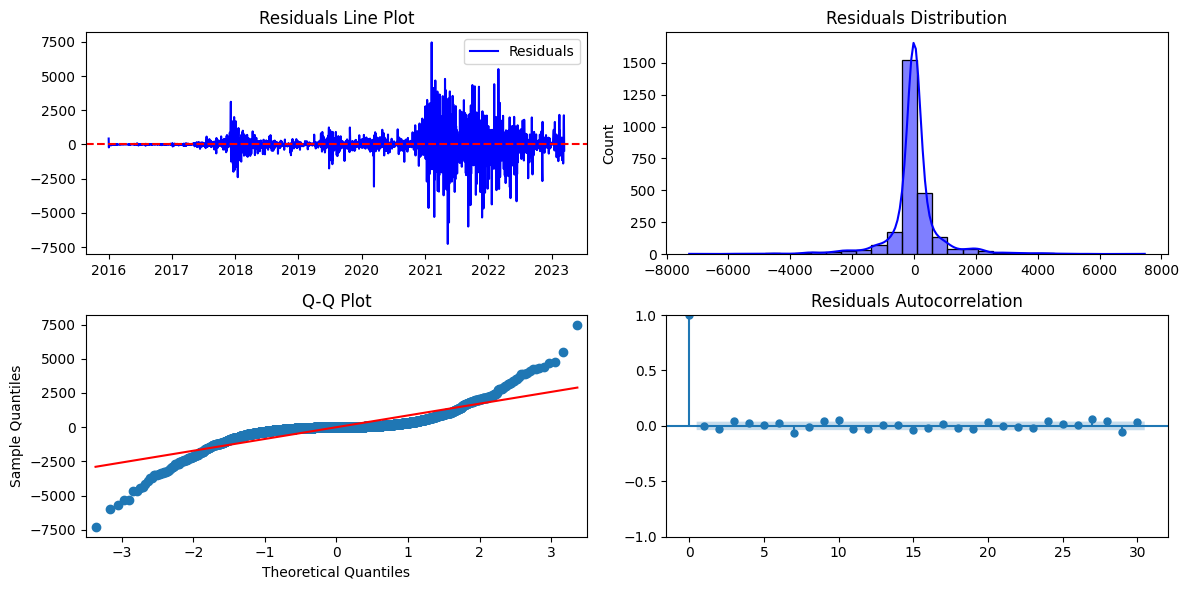

In [63]:
residuals = model_fit.resid


plt.figure(figsize=(12, 6))

# Line plot
plt.subplot(2, 2, 1)
plt.plot(residuals, label="Residuals", color="blue")
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals Line Plot")
plt.legend()

# Density plot
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, color="blue", bins=30)
plt.title("Residuals Distribution")

# Q-Q plot
plt.subplot(2, 2, 3)
qqplot(residuals, line="s", ax=plt.gca())
plt.title("Q-Q Plot")

# Autocorrelation plot
plt.subplot(2, 2, 4)
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title("Residuals Autocorrelation")

plt.tight_layout()
plt.show()

#### Rolling Forecast ARIMA

A rolling forecast involves retraining the model on a fixed-size window of past data (we will use it for 1 day period) and then using it to make predictions for the next period. Once the prediction is made, the window "rolls" forward by one period, and the model is updated with the new data.

In [27]:
df = bitcoin_data.copy()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

price = df['Price']
size = int(len(price) * 0.8)
train, test = price[:size], price[size:]

history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [77]:
# Evaluate the performance using RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 1277.268


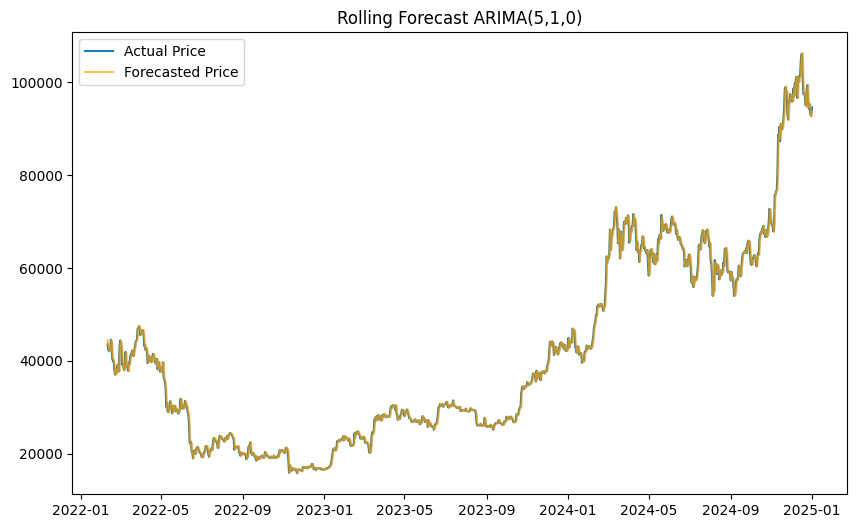

In [ ]:
# plot forecasts against actual outcomes
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual Price")
plt.plot(test.index, predictions, color='orange', label="Forecasted Price", alpha=0.7)
plt.title("Rolling Forecast ARIMA(5,1,0)")
plt.legend()
plt.show()

#### GARCH

This model is commonly used for forecasting and modeling financial time series data, particularly in cases where volatility is important. Unlike models that focus purely on predicting prices, GARCH models aim to model the time-varying volatility that often occurs in financial markets. This is particularly useful for modeling asset returns, such as Bitcoin prices, which can experience significant fluctuations in volatility over time.

In [50]:
data_garch = bitcoin.copy()
data_garch

,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,SMA_30
Date,,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN,NaN
...,...,...,...,...,...,...
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429,98661.200000
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571,98537.143333
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714,98416.280000


In [51]:
data_garch['Returns'] = (np.log(data_garch['Price'] / data_garch['Price'].shift(1))) *100
data_garch.drop(columns=['Price', 'Close_Diff', 'Close_Log', 'Close_Log_Diff', 'SMA_7', 'SMA_30'], inplace=True)
data_garch

,Returns
Date,
2016-01-02,NaN
2016-01-03,-0.694126
2016-01-04,0.601854
2016-01-05,-0.485831
2016-01-06,-0.092807
...,...
2024-12-28,1.064156
2024-12-29,-1.659502
2024-12-30,-1.004319


In [ ]:
data_garch.fillna(method='bfill', inplace = True)

In [16]:
last_year_garch = data_garch[data_garch.index >= "2024-01-01"]
last_month_garch = data_garch[data_garch.index >= "2024-12-01"]

In [53]:
train_size = int(len(data_garch) * 0.8)
g_train, g_test = data_garch.iloc[:train_size], data_garch.iloc[train_size:]

In [18]:
#Finding the best model of GARCH


p_values = [1, 2, 3]
q_values = [1, 2, 3]

best_aic = np.inf
best_bic = np.inf
best_model = None
best_p, best_q = None, None

for p in p_values:
    for q in q_values:
        try:
            model = arch_model(g_train['Returns'], vol='Garch', p=p, q=q, mean='Constant')
            model_fit = model.fit(disp='off')
            
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_model = model_fit
                best_p, best_q = p, q

        except Exception as e:
            print(f"Error fitting GARCH({p},{q}): {e}")

print(f"Best Model: GARCH({best_p},{best_q})")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best Model: GARCH(1,3)
AIC: 14270.501875056107
BIC: 14305.750309807137


In [54]:
model = arch_model(g_train['Returns'], vol='Garch', p=1, q=3, mean='Constant', dist='normal')
fit = model.fit(disp="off")

horizon = len(g_test['Returns'])
forecast = fit.forecast(horizon=horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.values[-1])

actual_volatility = g_test['Returns']**2  
mse = mean_squared_error(actual_volatility, forecasted_volatility**2) 
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 625.9269058450063


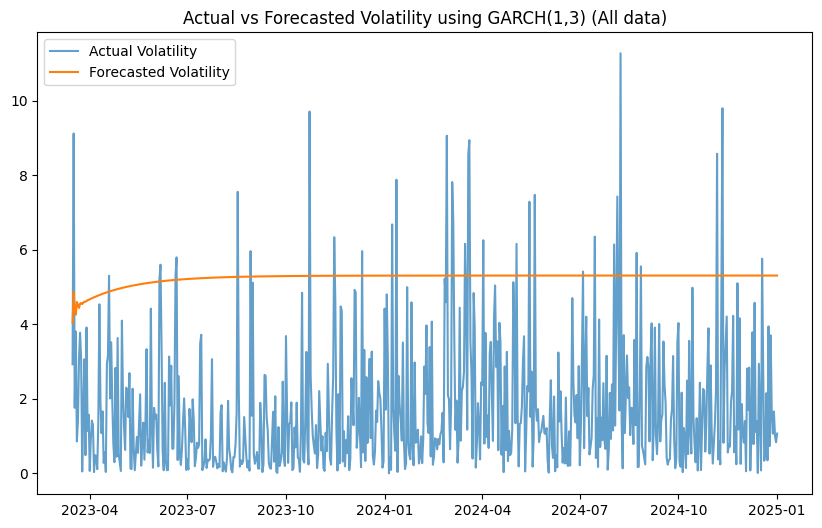

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(g_test.index,  np.sqrt(actual_volatility), label="Actual Volatility", alpha=0.7)
plt.plot(g_test.index, forecasted_volatility, label="Forecasted Volatility")
plt.title("Actual vs Forecasted Volatility using GARCH(1,3) (All data)")
plt.legend()
plt.show()

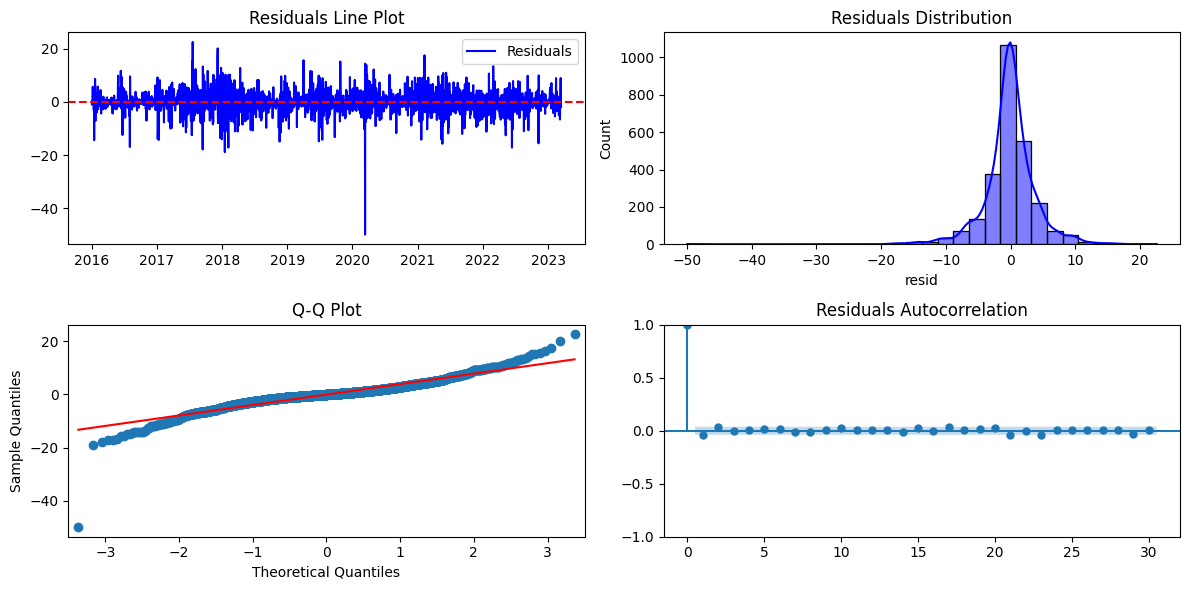

In [56]:
residuals = fit.resid


plt.figure(figsize=(12, 6))

# Line plot
plt.subplot(2, 2, 1)
plt.plot(residuals, label="Residuals", color="blue")
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals Line Plot")
plt.legend()

# Density plot
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, color="blue", bins=30)
plt.title("Residuals Distribution")

# Q-Q plot
plt.subplot(2, 2, 3)
qqplot(residuals, line="s", ax=plt.gca())
plt.title("Q-Q Plot")

# Autocorrelation plot
plt.subplot(2, 2, 4)
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title("Residuals Autocorrelation")

plt.tight_layout()
plt.show()

Now, we will use Grach for predicting volatility based on the last year and on the last month. Since the perioods are shorter, we will use the basic GARCH(1,1)

In [35]:
#GARCH for the last year
train_size = int(len(last_year_garch) * 0.8)
g_train, g_test = last_year_garch.iloc[:train_size], last_year_garch.iloc[train_size:]

In [36]:
g_train

,Returns
Date,
2024-01-01,4.421240
2024-01-02,1.706144
2024-01-03,-4.802939
2024-01-04,3.037026
2024-01-05,-0.000226
...,...
2024-10-15,1.495681
2024-10-16,0.802407
2024-10-17,-0.295476


In [22]:
model = arch_model(g_train['Returns'], vol='Garch', p=1, q=1, mean='Constant', dist='normal')
fit = model.fit(disp="off")

horizon = len(g_test['Returns'])
forecast = fit.forecast(horizon=horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.values[-1])

actual_volatility = g_test['Returns']**2  
mse = mean_squared_error(actual_volatility, forecasted_volatility**2) 
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 218.36923295972895


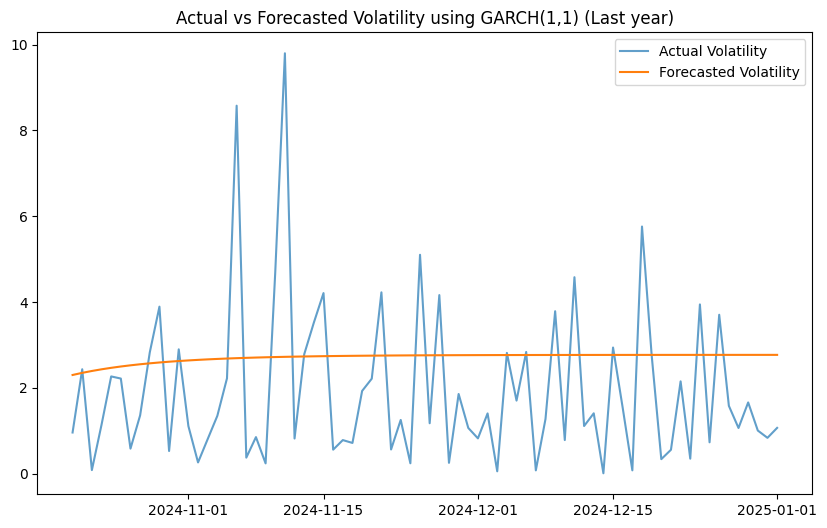

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(g_test.index,  np.sqrt(actual_volatility), label="Actual Volatility", alpha=0.7)
plt.plot(g_test.index, forecasted_volatility, label="Forecasted Volatility")
plt.title("Actual vs Forecasted Volatility using GARCH(1,1) (Last year)")
plt.legend()
plt.show()

In [33]:
#GARCH for the last month
train_size = int(len(last_month_garch) * 0.8)
g_train, g_test = last_month_garch.iloc[:train_size], last_month_garch.iloc[train_size:]

In [34]:
g_train

,Returns
Date,
2024-12-01,0.821979
2024-12-02,-1.403612
2024-12-03,0.054343
2024-12-04,2.814185
2024-12-05,-1.702438
2024-12-06,2.836442
2024-12-07,0.076454
2024-12-08,1.272754
2024-12-09,-3.785711


In [26]:
model = arch_model(g_train['Returns'], vol='Garch', p=1, q=1, mean='Constant', dist='normal')
fit = model.fit(disp="off")

horizon = len(g_test['Returns'])
forecast = fit.forecast(horizon=horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.values[-1])

actual_volatility = g_test['Returns']**2 
mse = mean_squared_error(actual_volatility, forecasted_volatility**2) 
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 28.987998390230633


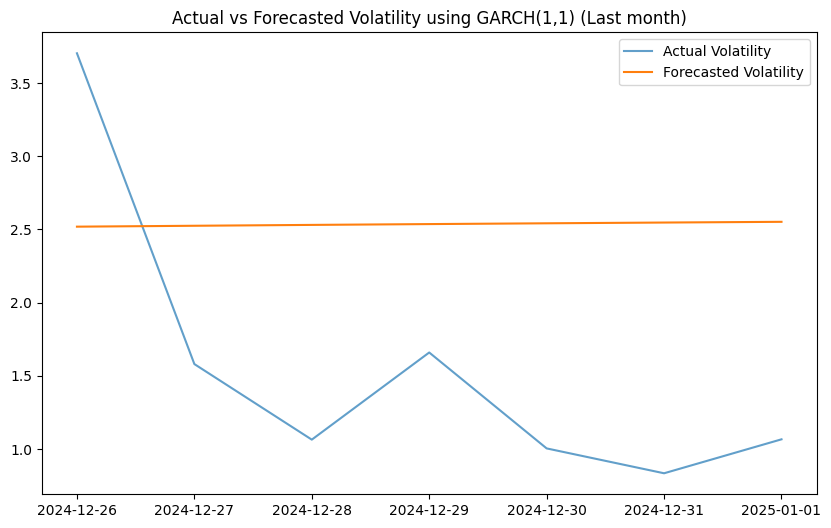

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(g_test.index,  np.sqrt(actual_volatility), label="Actual Volatility", alpha=0.7)
plt.plot(g_test.index, forecasted_volatility, label="Forecasted Volatility")
plt.title("Actual vs Forecasted Volatility using GARCH(1,1) (Last month)")
plt.legend()
plt.show()

The lines are straight or almost straight, that is why we will check how the rolling forecast will handle our data.

#### Rolling forecast GARCH

A rolling forecast involves retraining the model on a fixed-size window of past data (we will use it for 1 day period) and then using it to make predictions for the next period. Once the prediction is made, the window "rolls" forward by one period, and the model is updated with the new data.

In [29]:
data_garch

,Returns
Date,
2016-01-02,-0.694126
2016-01-03,-0.694126
2016-01-04,0.601854
2016-01-05,-0.485831
2016-01-06,-0.092807
...,...
2024-12-28,1.064156
2024-12-29,-1.659502
2024-12-30,-1.004319


In [30]:
tstart = "2016-01-02"
tend = "2023-03-15"

In [31]:
def train_test_split_garch(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = data_garch.loc[tstart:tend, "Returns"].values
    test = data_garch.loc[tend_next:, "Returns"].values
    return train, test

training_set_garch, test_set_garch = train_test_split_garch(data_garch, tstart, tend)


In [32]:
#Rolling forecast using 1 day window
test_size = len(test_set_garch)
rolling_predictions = []
for i in range(test_size):
    train = data_garch['Returns'][:-(test_size-i)]
    model = arch_model(train, p=1, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

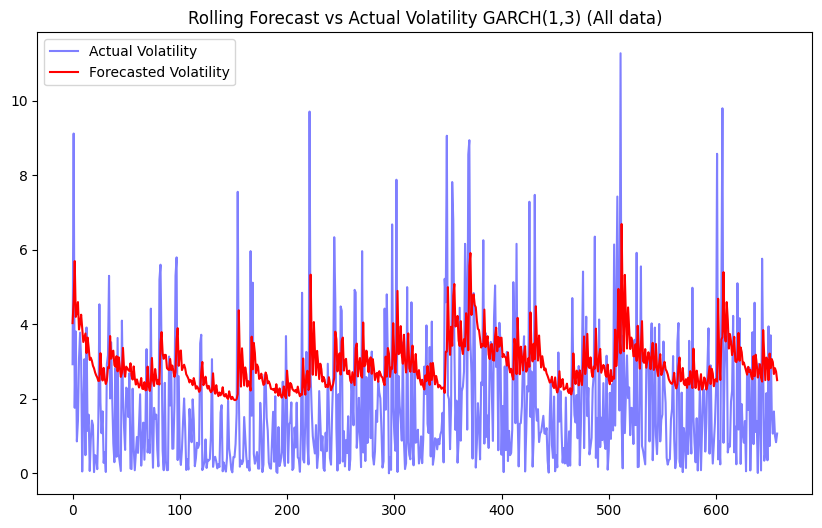

In [37]:
actual_volatility = np.sqrt(test_set_garch**2) 
plt.figure(figsize=(10, 6))
plt.plot(actual_volatility, label="Actual Volatility", color='blue', alpha=0.5)
plt.plot(rolling_predictions, label="Forecasted Volatility", color='red')
plt.title("Rolling Forecast vs Actual Volatility GARCH(1,3) (All data)")
plt.legend()
plt.show()

In [40]:
#Rolling forecast for the last year
tstart = "2024-01-01"
tend = "2024-10-19"

In [41]:
def train_test_split_garch(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = data_garch.loc[tstart:tend, "Returns"].values
    test = data_garch.loc[tend_next:, "Returns"].values
    return train, test

training_set_garch, test_set_garch = train_test_split_garch(data_garch, tstart, tend)


In [42]:
#Rolling forecast using 1 day window
test_size = len(test_set_garch)
rolling_predictions = []
for i in range(test_size):
    train = data_garch['Returns'][:-(test_size-i)]
    model = arch_model(train, p=1, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

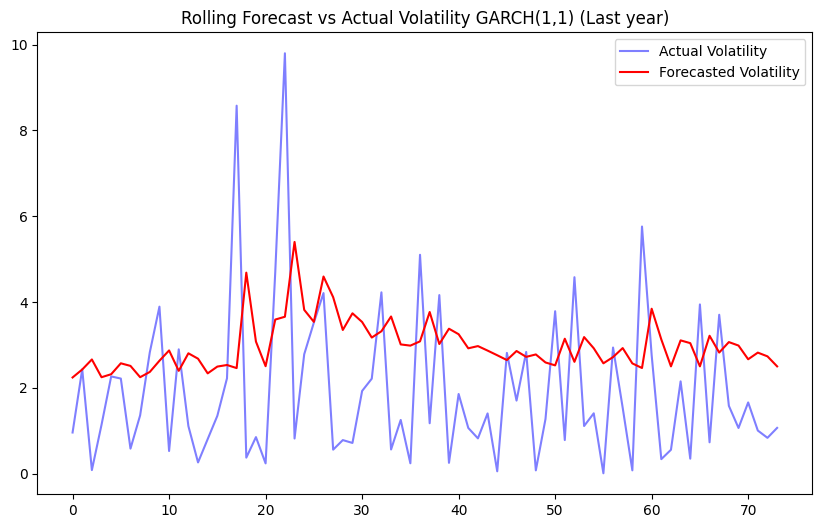

In [44]:
actual_volatility = np.sqrt(test_set_garch**2) 
plt.figure(figsize=(10, 6))
plt.plot(actual_volatility, label="Actual Volatility", color='blue', alpha=0.5)
plt.plot(rolling_predictions, label="Forecasted Volatility", color='red')
plt.title("Rolling Forecast vs Actual Volatility GARCH(1,1) (Last year)")
plt.legend()
plt.show()

In [45]:
#Rolling forecast for the last year
tstart = "2024-12-01"
tend = "2024-12-25"

In [46]:
def train_test_split_garch(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = data_garch.loc[tstart:tend, "Returns"].values
    test = data_garch.loc[tend_next:, "Returns"].values
    return train, test

training_set_garch, test_set_garch = train_test_split_garch(data_garch, tstart, tend)

In [47]:
#Rolling forecast using 1 day window
test_size = len(test_set_garch)
rolling_predictions = []
for i in range(test_size):
    train = data_garch['Returns'][:-(test_size-i)]
    model = arch_model(train, p=1, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

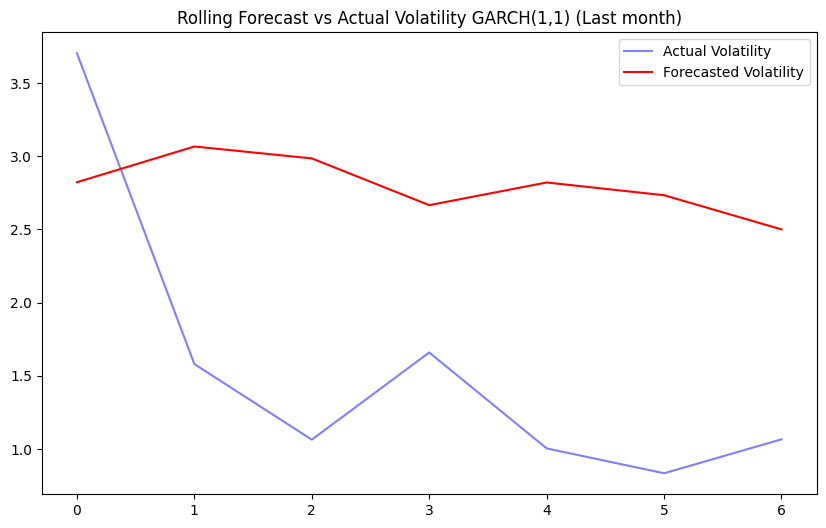

In [49]:
actual_volatility = np.sqrt(test_set_garch**2) 
plt.figure(figsize=(10, 6))
plt.plot(actual_volatility, label="Actual Volatility", color='blue', alpha=0.5)
plt.plot(rolling_predictions, label="Forecasted Volatility", color='red')
plt.title("Rolling Forecast vs Actual Volatility GARCH(1,1) (Last month)")
plt.legend()
plt.show()

The rolling forecast of volatility using the GARCH model provides a more dynamic view of how Bitcoin's volatility changes over time. It works fine for the all data and for the last year. Unfortunately it does not cover with the data of the last month.